# Dự Báo Doanh Số Và Phân Tích Lợi Nhuận Cho Chuỗi Siêu Thị

## 1. Giới thiệu Dự án

Dự án này tập trung vào việc *dự báo doanh số bán hàng* và *phân tích lợi nhuận* của chuỗi cửa hàng bán lẻ (Superstore) bằng các mô hình chuỗi thời gian (time series) và *phân tích dữ liệu kinh doanh*.

* Mục tiêu chính:
    * Dự báo doanh số (Sales Forecasting) cho Superstore trong 6 tháng tới bằng mô hình Holt-Winter Forecast.
    * Phân tích lợi nhuận (Profit Analysis) để xác định yếu tố ảnh hưởng đến lợi nhuận, phân khúc khách hàng và danh mục hàng hóa hiệu quả.
    * Đề xuất chiến lược cải thiện doanh thu và lợi nhuận dựa trên kết quả mô hình và insight thực tế.

## 2. Phương pháp (Methodology)

* **Phân tích mô tả (Descriptive Analysis):**
  Sử dụng các chỉ số thống kê và biểu đồ trực quan (cột, đường, heatmap) để nhận diện xu hướng kinh doanh chính như doanh thu theo tháng, phân bố đơn hàng theo phương thức vận chuyển và tác động của chiết khấu đến lợi nhuận.

* **Phân tích tương quan (Correlation Analysis):**
  Đánh giá mối quan hệ giữa các biến kinh doanh chủ chốt — chiết khấu, doanh thu, lợi nhuận và biên lợi nhuận — nhằm xác định ảnh hưởng của chính sách chiết khấu đến hiệu quả hoạt động.

* **Mô hình dự báo (Forecasting Model):**
  Áp dụng mô hình Holt–Winters Exponential Smoothing để dự báo doanh thu 6–12 tháng tới, tận dụng đặc điểm xu hướng (*trend*) và mùa vụ (*seasonality*) của dữ liệu.

* **Kiểm định:**
  Xây dựng các kịch bản giảm chiết khấu để phân tích tác động tiềm năng đến doanh thu và lợi nhuận, hỗ trợ ra quyết định kinh doanh chiến lược.


## 3. Phân tích (Analysis)

### 3.1. Chuẩn bị dữ liệu

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [356]:
df = pd.read_csv('Sample_Superstore.csv', encoding='ISO-8859-1', parse_dates=['Order Date','Ship Date'])
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**Kiểm tra tổng quan**

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

**Data Cleaning**

In [358]:
# Chuẩn hóa tên cột
df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_').str.lower()
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [359]:
#  Kiểm tra các giá trị trùng lặp
df.duplicated().sum()

np.int64(0)

In [360]:
# Xóa các giá trị trùng lặp
df.drop_duplicates(inplace=True)

In [361]:
# Kiểm tra dữ liệu bị thiếu
df.isnull().sum()

,0
row_id,0
order_id,0
order_date,0
ship_date,0
ship_mode,0
customer_id,0
customer_name,0
segment,0
country,0
city,0


In [362]:
# Loại bỏ các dòng thiếu thông tin cần thiết
df = df.dropna(subset=['sales', 'ship_mode', 'region', 'segment'])

In [363]:
# Xử lý datatypes
df = df.convert_dtypes()

In [364]:
# Chuyển các cột cần thiết về dạng "category"
cols = ['country','city','state','region','category','sub_category']
df[cols] = df[cols].astype('category')

In [365]:
# Kiểm tra lại thông tin data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9994 non-null   Int64         
 1   order_id       9994 non-null   string        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   datetime64[ns]
 4   ship_mode      9994 non-null   string        
 5   customer_id    9994 non-null   string        
 6   customer_name  9994 non-null   string        
 7   segment        9994 non-null   string        
 8   country        9994 non-null   category      
 9   city           9994 non-null   category      
 10  state          9994 non-null   category      
 11  postal_code    9994 non-null   Int64         
 12  region         9994 non-null   category      
 13  product_id     9994 non-null   string        
 14  category       9994 non-null   category      
 15  sub_category   9994 n

### 3.2. Phân tích khám phá dữ liệu (EDA)

In [366]:
# Chi phí ước tính cho mỗi giao dịch
df['cost'] = df['sales'] - df['profit']

# Tỷ suất lợi nhuận
df['profit_margin'] = (df['profit'] / df['sales']) * 100

# Thời gian vận chuyển
df['shipping_time'] = (df['ship_date'] - df['order_date']).dt.days.astype(int)

# Giá bán trung bình cho mỗi sản phẩm
df['sales_per_quantity'] = df['sales'] / df['quantity']

# Đơn hàng lãi/lỗ
df['is_gain']=np.where(df['profit']>0,1,0)

In [367]:
# Xử lý cột thời gian
df['month_order']=df['order_date'].dt.month
df['year_order']=df['order_date'].dt.year

In [368]:
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit', 'cost',
       'profit_margin', 'shipping_time', 'sales_per_quantity', 'is_gain',
       'month_order', 'year_order'],
      dtype='object')

In [369]:
df.shape

(9994, 28)

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   row_id              9994 non-null   Int64         
 1   order_id            9994 non-null   string        
 2   order_date          9994 non-null   datetime64[ns]
 3   ship_date           9994 non-null   datetime64[ns]
 4   ship_mode           9994 non-null   string        
 5   customer_id         9994 non-null   string        
 6   customer_name       9994 non-null   string        
 7   segment             9994 non-null   string        
 8   country             9994 non-null   category      
 9   city                9994 non-null   category      
 10  state               9994 non-null   category      
 11  postal_code         9994 non-null   Int64         
 12  region              9994 non-null   category      
 13  product_id          9994 non-null   string      

### 3.3. Tổng quan hiệu suất kinh doanh

In [371]:
df.describe()

,row_id,order_date,ship_date,postal_code,sales,quantity,discount,profit,cost,profit_margin,shipping_time,sales_per_quantity,is_gain,month_order,year_order
count,9994.0,9994,9994,9994.0,9994.0,9994.0,9994.0,9994.0,9994.0,9994.0,9994.000000,9994.0,9994.000000,9994.000000,9994.000000
mean,4997.5,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896,201.201105,12.031393,3.958175,60.919569,0.806284,7.809686,2015.722233
min,1.0,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.0,0.444,1.0,0.0,-6599.978,0.5544,-275.0,0.000000,0.336,0.000000,1.000000,2014.000000
25%,2499.25,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.0,17.28,2.0,0.0,1.72875,12.6882,7.5,3.000000,5.47,1.000000,5.000000,2015.000000
50%,4997.5,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.5,54.49,3.0,0.2,8.6665,41.664,27.0,4.000000,16.27,1.000000,9.000000,2016.000000
75%,7495.75,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.0,209.94,5.0,0.2,29.364,182.2263,36.25,5.000000,63.94,1.000000,11.000000,2017.000000
max,9994.0,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.0,22638.48,14.0,0.8,8399.976,24449.5584,50.0,7.000000,3773.08,1.000000,12.000000,2017.000000
std,2885.163629,NaN,NaN,32063.69335,623.245101,2.22511,0.206452,234.260108,550.839414,46.675435,1.747567,142.92744,0.395229,3.284654,1.123555


In [372]:
# --- Tính tổng doanh thu, lợi nhuận và biên lợi nhuận trung bình ---
total_sales = df['sales'].sum()
total_profit = df['profit'].sum()
avg_margin = (total_profit / total_sales) * 100

print(" HIỆU QUẢ KINH DOANH TỔNG QUAN")
print("Tổng doanh thu:", round(total_sales, 2))
print("Tổng lợi nhuận:", round(total_profit, 2))
print("Biên lợi nhuận trung bình:", round(avg_margin, 2), "%")

# --- Tính tỷ lệ đơn hàng có lãi và lỗ ---
total_orders = len(df)
gain_orders = df['is_gain'].sum()
loss_orders = total_orders - gain_orders

gain_rate = (gain_orders / total_orders) * 100
loss_rate = (loss_orders / total_orders) * 100

print("\n PHÂN BỔ ĐƠN HÀNG CÓ LÃI / LỖ")
print("Đơn hàng có lãi:", gain_orders, "(", round(gain_rate, 2), "% )")
print("Đơn hàng lỗ:", loss_orders, "(", round(loss_rate, 2), "% )")

# --- Tính chiết khấu trung bình ---
avg_discount = df['discount'].mean() * 100
print("\nChiết khấu trung bình:", round(avg_discount, 2), "%")


 HIỆU QUẢ KINH DOANH TỔNG QUAN
Tổng doanh thu: 2297200.86
Tổng lợi nhuận: 286397.02
Biên lợi nhuận trung bình: 12.47 %

 PHÂN BỔ ĐƠN HÀNG CÓ LÃI / LỖ
Đơn hàng có lãi: 8058 ( 80.63 % )
Đơn hàng lỗ: 1936 ( 19.37 % )

Chiết khấu trung bình: 15.62 %


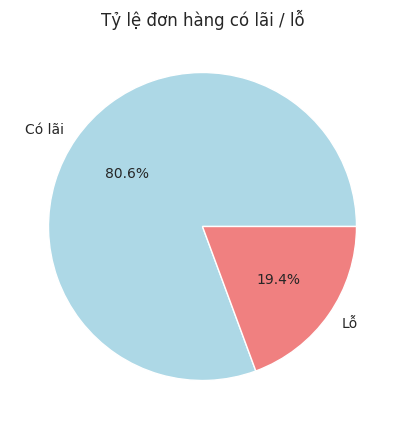

In [373]:
# --- Vẽ biểu đồ tròn thể hiện tỷ lệ đơn hàng có lãi / lỗ ---
plt.figure(figsize=(5,5))
plt.pie([gain_orders, loss_orders],
        labels=['Có lãi', 'Lỗ'],
        autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Tỷ lệ đơn hàng có lãi / lỗ')
plt.show()

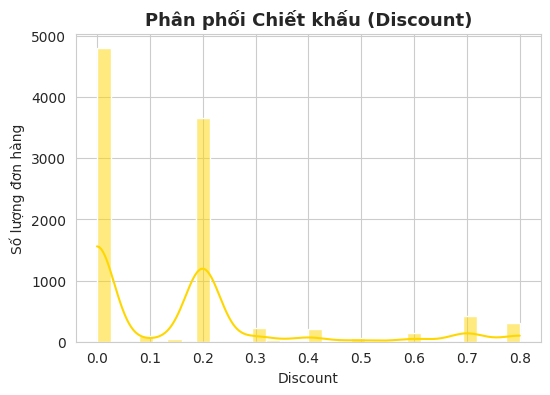

In [374]:
# --- Histogram phân phối Discount ---
plt.figure(figsize=(6,4))
sns.histplot(df['discount'], bins=30, color='gold', kde=True)
plt.title('Phân phối Chiết khấu (Discount)', fontsize=13, fontweight='bold')
plt.xlabel('Discount')
plt.ylabel('Số lượng đơn hàng')
plt.show()

/tmp/ipython-input-2819375479.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_profit = df.groupby('region')['profit'].sum().reset_index()
/tmp/ipython-input-2819375479.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=region_profit.sort_values('profit', ascending=False),


Vùng có LỢI NHUẬN CAO NHẤT:
region           West
profit    108418.4489
Name: 3, dtype: object

 Vùng có LỢI NHUẬN THẤP NHẤT:
region       Central
profit    39706.3625
Name: 0, dtype: object


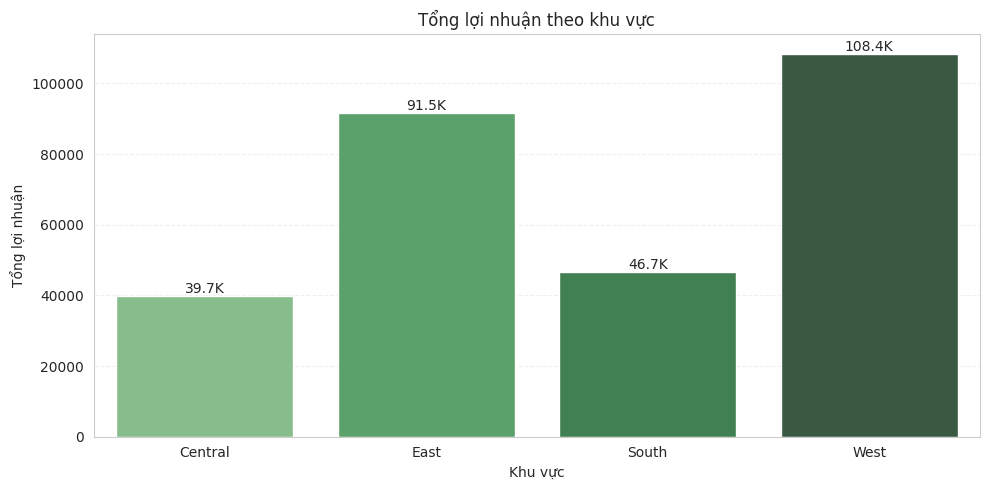

In [375]:
# Tính tổng lợi nhuận theo vùng
region_profit = df.groupby('region')['profit'].sum().reset_index()

# Vùng có lợi nhuận cao nhất và thấp nhất
top_profit_region = region_profit.loc[region_profit['profit'].idxmax()]
bottom_profit_region = region_profit.loc[region_profit['profit'].idxmin()]

print("Vùng có LỢI NHUẬN CAO NHẤT:")
print(top_profit_region)

print("\n Vùng có LỢI NHUẬN THẤP NHẤT:")
print(bottom_profit_region)

plt.figure(figsize=(10,5))
ax = sns.barplot(data=region_profit.sort_values('profit', ascending=False),
            x='region', y='profit', palette='Greens_d')

plt.title('Tổng lợi nhuận theo khu vực')
plt.xlabel('Khu vực')
plt.ylabel('Tổng lợi nhuận')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height,
        s=f'{height/1000:.1f}K',ha='center',va='bottom',fontsize=10
    )

plt.tight_layout()
plt.show()

**Phân bổ số lượng đơn hàng theo vùng, sản phẩm và phân khúc**

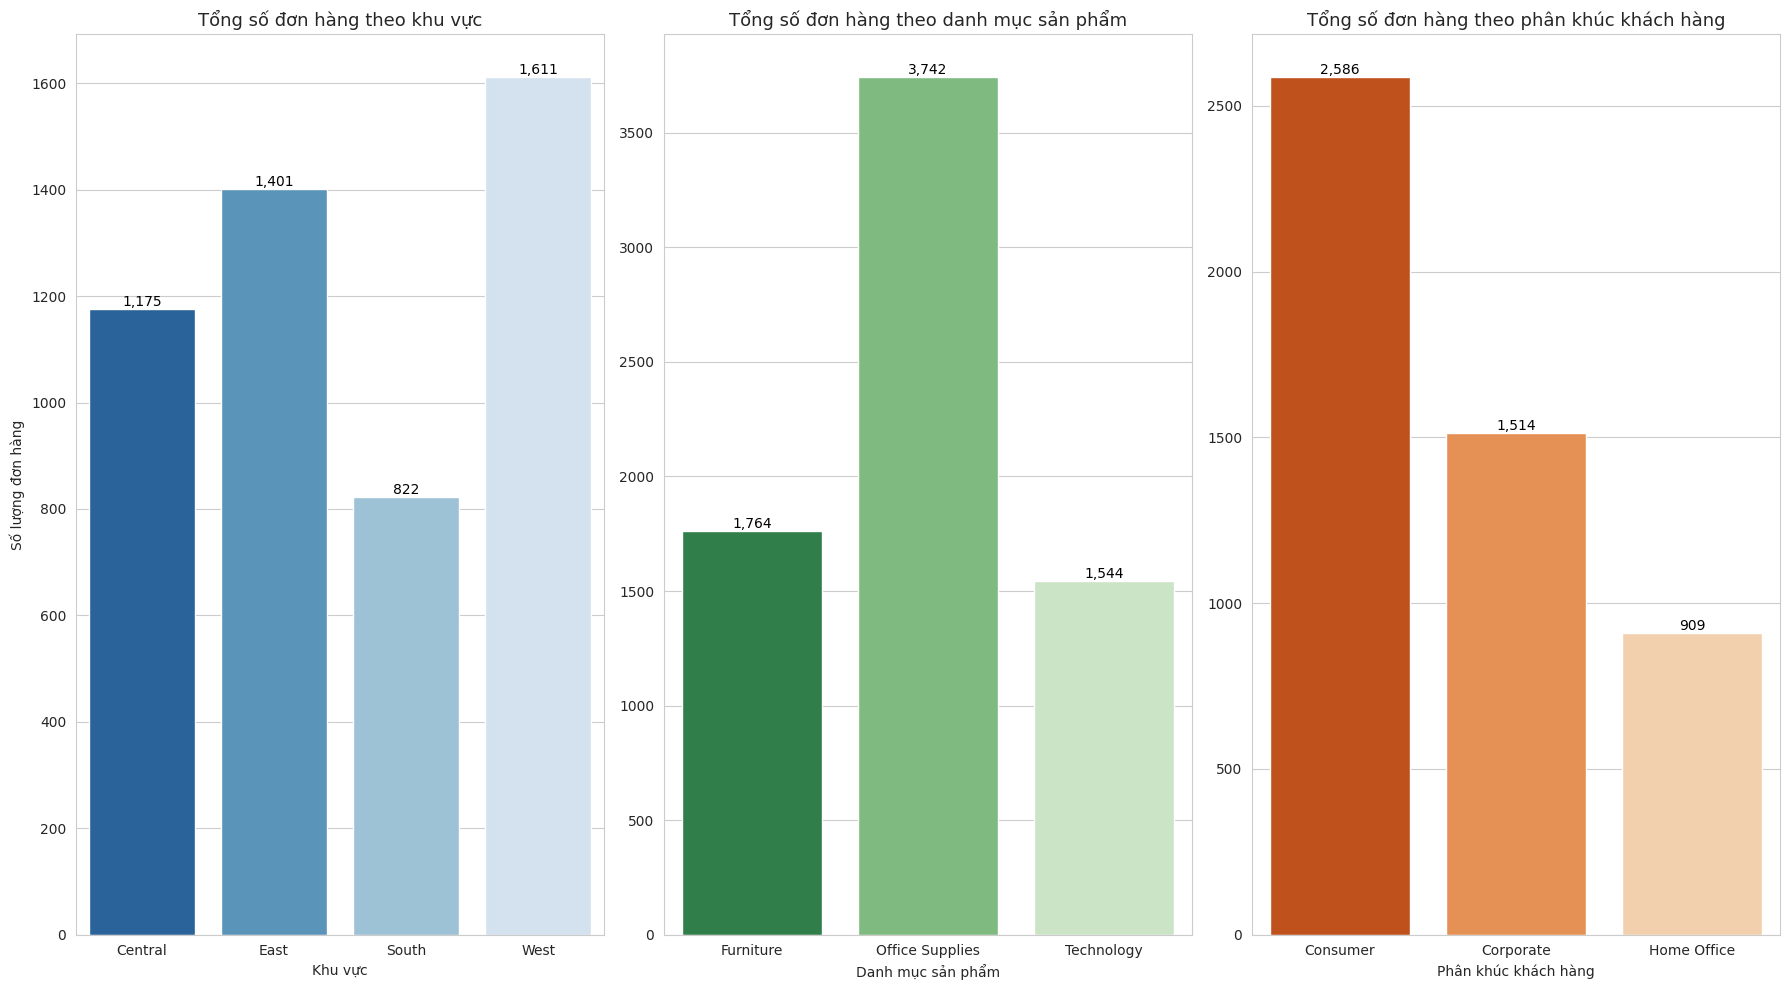

In [376]:
# --- 3 bảng tổng hợp ---
orders_by_region = df.groupby('region', observed=True)['order_id'].nunique().reset_index()
orders_by_category = df.groupby('category', observed=True)['order_id'].nunique().reset_index()
orders_by_segment = df.groupby('segment', observed=True)['order_id'].nunique().reset_index()

# --- Tạo figure với 3 biểu đồ trong 1 hàng ---
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# --- Biểu đồ 1: Tổng số đơn hàng trên khắp khu vực ---
sns.barplot(x='region', y='order_id', data=orders_by_region, ax=axes[0], hue='region', palette='Blues_r')
axes[0].set_title('Tổng số đơn hàng theo khu vực', fontsize=13)
axes[0].set_xlabel('Khu vực')
axes[0].set_ylabel('Số lượng đơn hàng')

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')

# --- Biểu đồ 2: Tổng số đơn hàng theo danh mục sản phẩm ---
sns.barplot(x='category', y='order_id', data=orders_by_category, ax=axes[1], hue='category', palette='Greens_r')
axes[1].set_title('Tổng số đơn hàng theo danh mục sản phẩm', fontsize=13)
axes[1].set_xlabel('Danh mục sản phẩm')
axes[1].set_ylabel('')

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')

# --- Biểu đồ 3: Tổng số đơn hàng theo phân khúc ---
sns.barplot(x='segment', y='order_id', data=orders_by_segment, ax=axes[2], hue='segment', palette='Oranges_r')
axes[2].set_title('Tổng số đơn hàng theo phân khúc khách hàng', fontsize=13)
axes[2].set_xlabel('Phân khúc khách hàng')
axes[2].set_ylabel('')

for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()



### 3.4. Xu hướng doanh số theo thời gian

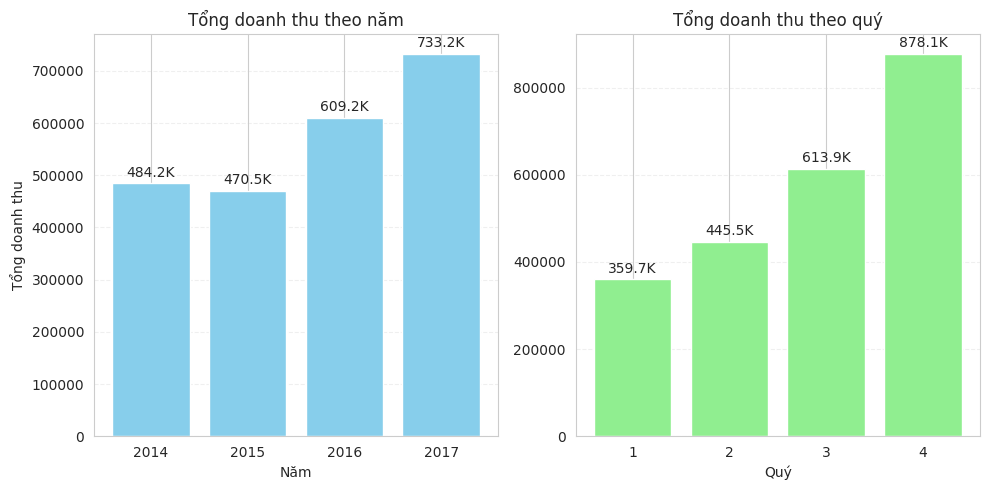

In [377]:
# ------ TỔNG QUAN THEO NĂM & QUÝ ------

# --- Tính tổng doanh số theo năm ---
yearly_sales = df.groupby('year_order')['sales'].sum().reset_index()

# --- Tính tổng doanh số theo quý ---
df['quarter_order'] = df['order_date'].dt.quarter
quarterly_sales = df.groupby('quarter_order')['sales'].sum().reset_index()

# --- Tạo 2 biểu đồ cạnh nhau ---
plt.figure(figsize=(10,5))

# Biểu đồ 1: Doanh số theo năm
plt.subplot(1, 2, 1)  # (1 hàng, 2 cột, biểu đồ thứ 1)
plt.bar(yearly_sales['year_order'], yearly_sales['sales'], color='skyblue')
plt.title('Tổng doanh thu theo năm')
plt.xlabel('Năm')
plt.ylabel('Tổng doanh thu')
plt.xticks(yearly_sales['year_order'])
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate(yearly_sales['sales']):
    plt.text(yearly_sales['year_order'][i], v + max(yearly_sales['sales'])*0.01, f'{v/1000:.1f}K',
             ha='center', va='bottom')

# Biểu đồ 2: Doanh số theo quý
plt.subplot(1, 2, 2)  # (1 hàng, 2 cột, biểu đồ thứ 2)
plt.bar(quarterly_sales['quarter_order'], quarterly_sales['sales'], color='lightgreen')
plt.title('Tổng doanh thu theo quý')
plt.xlabel('Quý')
plt.ylabel('')
plt.xticks([1, 2, 3, 4])
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate(quarterly_sales['sales']):
    plt.text(quarterly_sales['quarter_order'][i], v + max(quarterly_sales['sales'])*0.01, f'{v/1000:.1f}K',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()



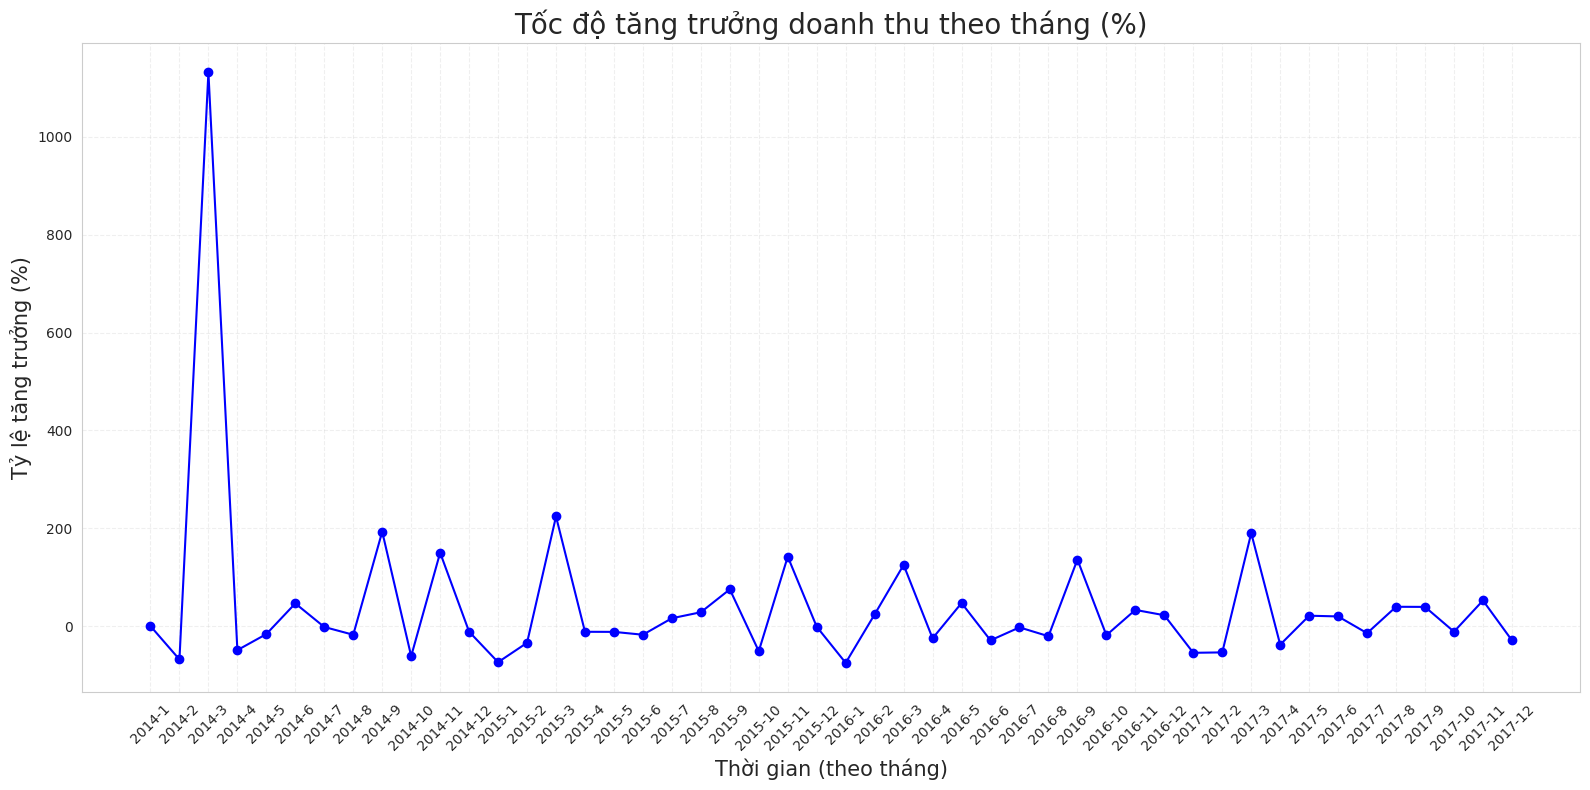

In [378]:
# ------ Kiểm tra tính mùa vụ (Seasonality) ------
# --- Tính tổng doanh số theo tháng ---
monthly_sales = df.groupby(['year_order', 'month_order'])['sales'].sum().reset_index()

# --- Tính tốc độ tăng trưởng theo tháng ---
monthly_sales['MoM Growth (%)'] = monthly_sales['sales'].pct_change() * 100
monthly_sales['MoM Growth (%)'] = monthly_sales['MoM Growth (%)'].fillna(0)
# --- Hiển thị kết quả ---
# print(monthly_sales)

monthly_sales['Period'] = monthly_sales['year_order'].astype(str) + '-' + monthly_sales['month_order'].astype(str)

plt.figure(figsize=(16,8))
plt.plot(monthly_sales['Period'], monthly_sales['MoM Growth (%)'], marker='o', color='blue')
plt.title('Tốc độ tăng trưởng doanh thu theo tháng (%)', fontsize=20)
plt.xlabel('Thời gian (theo tháng)', fontsize=15)
plt.ylabel('Tỷ lệ tăng trưởng (%)', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


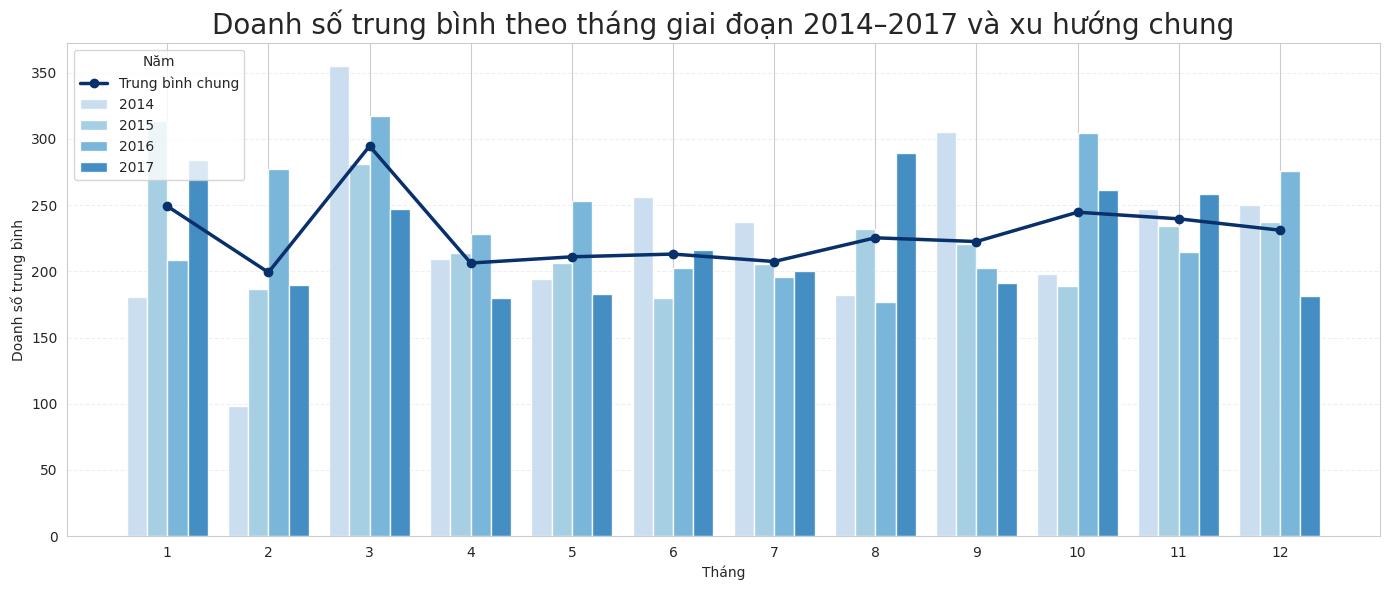

In [379]:
# --- Chuẩn bị dữ liệu ---
monthly_yearly_avg = df.groupby(['year_order', 'month_order'])['sales'].mean().reset_index()
monthly_avg_all = df.groupby('month_order')['sales'].mean().reset_index()

# --- Pivot để dễ vẽ ---
pivot = monthly_yearly_avg.pivot(index='month_order', columns='year_order', values='sales')
pivot = pivot.sort_index()

months = pivot.index.values
years = pivot.columns.tolist()
n_years = len(years)
base_x = np.arange(len(months))
width = 0.8 / n_years

# --- Bảng màu xanh cho các năm ---
blue_palette = ['#c6dbef', '#9ecae1', '#6baed6', '#3182bd']

plt.figure(figsize=(14,6))

# --- Vẽ cột (bar) ---
for i, (yr, color) in enumerate(zip(years, blue_palette)):
    offsets = (i - (n_years-1)/2) * width
    x_positions = base_x + offsets
    plt.bar(
        x_positions,
        pivot[yr].values,
        width=width,
        label=str(yr),
        color=color,
        alpha=0.9,
        zorder=2
    )

# --- Vẽ đường trung bình (Overall Avg) ---
overall_y = [monthly_avg_all.set_index('month_order').loc[m, 'sales'] for m in months]
plt.plot(
    base_x,
    overall_y,
    marker='o',
    linewidth=2.5,
    color='#08306b',
    label='Trung bình chung',
    zorder=3
)
plt.xticks(base_x, months)
plt.xlabel('Tháng')
plt.ylabel('Doanh số trung bình')
plt.title('Doanh số trung bình theo tháng giai đoạn 2014–2017 và xu hướng chung', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Năm', loc='upper left')
plt.tight_layout()
plt.show()


### 3.5. Phân tích theo vùng (Region)

**Vùng nào đang dẫn đầu doanh số?**

/tmp/ipython-input-803813906.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_sales = df.groupby('region')['sales'].sum().reset_index()
/tmp/ipython-input-803813906.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=region_sales.sort_values('sales', ascending=False),


Vùng có DOANH THU CAO NHẤT:
region           West
sales     725457.8245
Name: 3, dtype: object

Vùng có DOANH THU THẤP NHẤT:
region         South
sales     391721.905
Name: 2, dtype: object


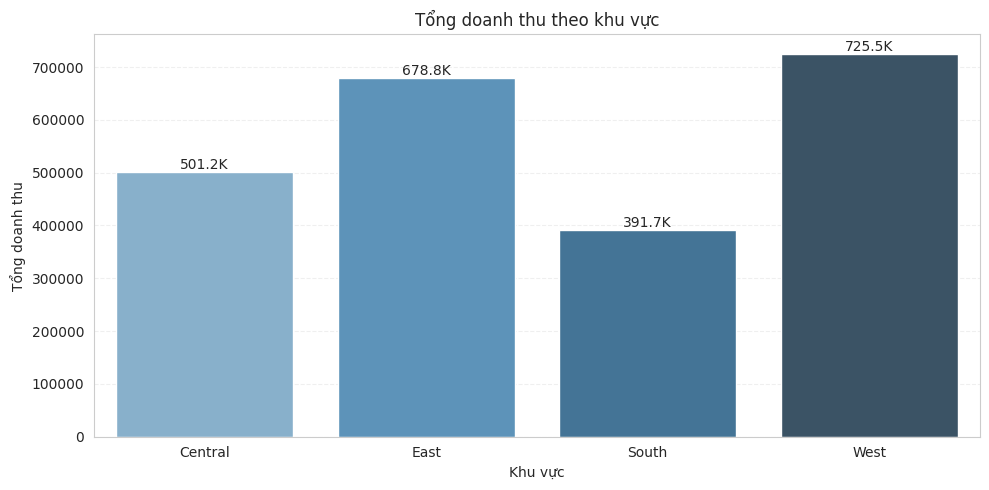

In [380]:
# Tính tổng doanh thu theo vùng
region_sales = df.groupby('region')['sales'].sum().reset_index()

# Vùng có doanh thu cao nhất và thấp nhất
top_region = region_sales.loc[region_sales['sales'].idxmax()]
bottom_region = region_sales.loc[region_sales['sales'].idxmin()]

print("Vùng có DOANH THU CAO NHẤT:")
print(top_region)

print("\nVùng có DOANH THU THẤP NHẤT:")
print(bottom_region)

plt.figure(figsize=(10,5))
ax = sns.barplot(data=region_sales.sort_values('sales', ascending=False),
            x='region', y='sales', palette='Blues_d')

plt.title('Tổng doanh thu theo khu vực')
plt.xlabel('Khu vực')
plt.ylabel('Tổng doanh thu')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height,s=f'{height/1000:.1f}K',ha='center',va='bottom',fontsize=10
    )

plt.tight_layout()
plt.show()

**Có vùng nào có Sales cao nhưng Profit Margin (%) thấp không?**

**Vùng nào thực sự kinh doanh hiệu quả nhất? (Biên lợi nhuận %)**

/tmp/ipython-input-834119079.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_summary = df.groupby('region')[['sales', 'profit']].sum().reset_index()
/tmp/ipython-input-834119079.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=region_summary.sort_values('Profit Margin (%)', ascending=False),


    region        sales       profit  Profit Margin (%)
0  Central  501239.8908   39706.3625           7.921629
1     East    678781.24     91522.78          13.483399
2    South   391721.905   46749.4303          11.934342
3     West  725457.8245  108418.4489          14.944831

 Vùng có BIÊN LỢI NHUẬN (%) CAO NHẤT:
region                      West
sales                725457.8245
profit               108418.4489
Profit Margin (%)      14.944831
Name: 3, dtype: object

 Vùng có BIÊN LỢI NHUẬN (%) THẤP NHẤT:
region                   Central
sales                501239.8908
profit                39706.3625
Profit Margin (%)       7.921629
Name: 0, dtype: object


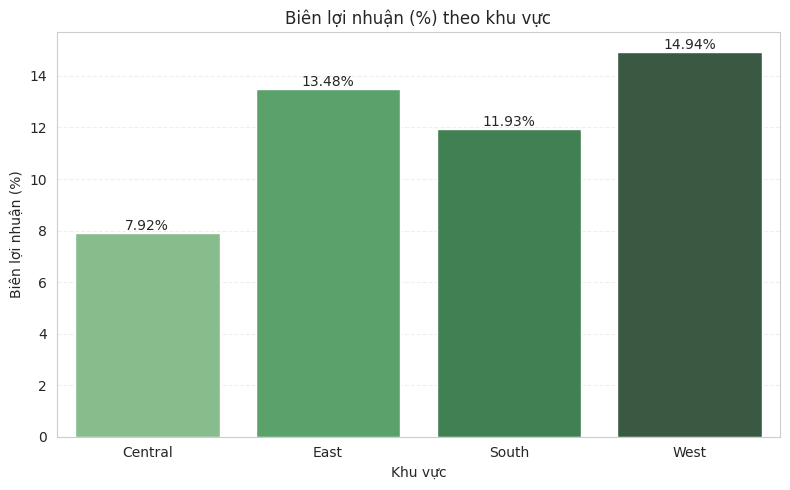

In [381]:
# ------ Profit Margin (%) cho từng vùng ------
# Tính tổng doanh thu và lợi nhuận theo vùng
region_summary = df.groupby('region')[['sales', 'profit']].sum().reset_index()

# Thêm cột biên lợi nhuận (%)
region_summary['Profit Margin (%)'] = (region_summary['profit'] / region_summary['sales']) * 100

print(region_summary)

# ------ Vùng có biên lợi nhuận cao nhất & thấp nhất ------
top_margin = region_summary.loc[region_summary['Profit Margin (%)'].idxmax()]
bottom_margin = region_summary.loc[region_summary['Profit Margin (%)'].idxmin()]

print("\n Vùng có BIÊN LỢI NHUẬN (%) CAO NHẤT:")
print(top_margin)

print("\n Vùng có BIÊN LỢI NHUẬN (%) THẤP NHẤT:")
print(bottom_margin)

# ------ Biểu đồ: Biên lợi nhuận theo vùng ------
plt.figure(figsize=(8,5))
ax = sns.barplot(data=region_summary.sort_values('Profit Margin (%)', ascending=False),
            x='region', y='Profit Margin (%)', palette='Greens_d')
plt.title('Biên lợi nhuận (%) theo khu vực')
plt.xlabel('Khu vực')
plt.ylabel('Biên lợi nhuận (%)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height,
        s=f'{height:.2f}%',ha='center',va='bottom',fontsize=10
    )
plt.tight_layout()
plt.show()

**Vùng có biên lợi nhuận thấp có phải là đang chịu lỗ hay không?**

/tmp/ipython-input-3484731141.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_loss = negative_df.groupby("region")["profit"].sum().sort_values()


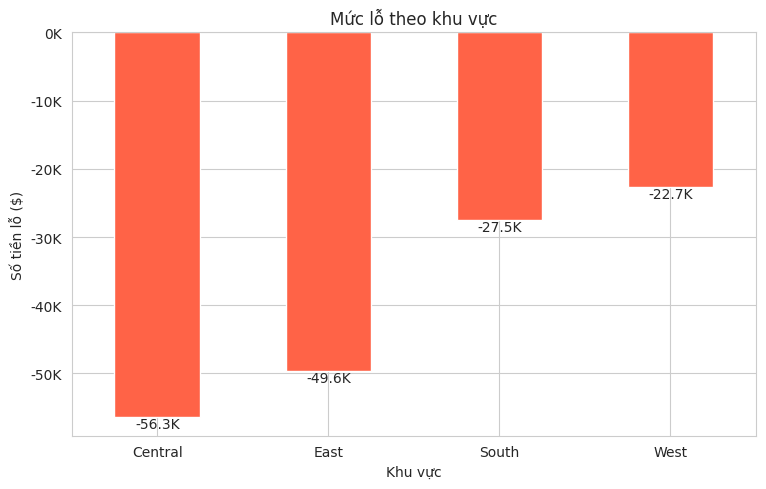

In [382]:
# Lọc các dòng có lợi nhuận âm và tính tổng lỗ theo từng khu vực
negative_df = df[df["profit"] < 0]
region_loss = negative_df.groupby("region")["profit"].sum().sort_values()

# Tạo biểu đồ cột thể hiện mức lỗ theo khu vực
plt.figure(figsize=(8,5))
bars = region_loss.plot(kind="bar", color="tomato")

plt.title("Mức lỗ theo khu vực")
plt.xlabel("Khu vực")
plt.ylabel("Số tiền lỗ ($)")
plt.xticks(rotation=0)
plt.tight_layout()

# Thêm nhãn giá trị lên đầu mỗi cột
for i, value in enumerate(region_loss):
    plt.text(i, value, f'{value/1000:.1f}K', ha='center', va='bottom' if value > 0 else 'top', fontsize=10)

# Định dạng trục tung theo đơn vị nghìn để dễ đọc hơn
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.show()


**Logistics tại khu vực trung tâm (central)**

Liệu logistics có phải là nguyên nhân khiến khu vực trung tâm trở thành khu vực thua lỗ nhiều nhất?


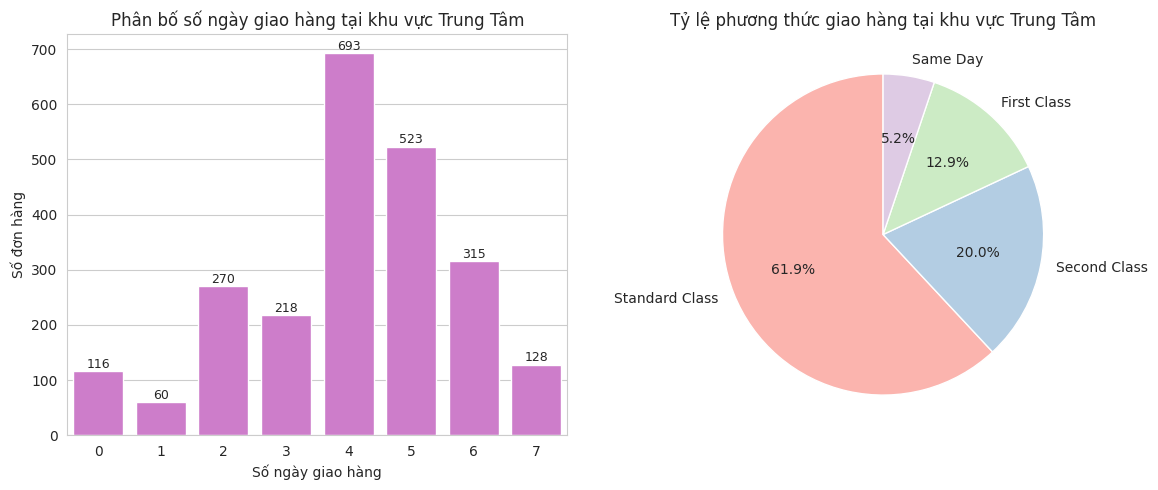

In [383]:
# Lọc dữ liệu cho khu vực Trung Tâm (Central)
central_df = df[df['region'] == 'Central'].copy()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Phần 1: Phân bố số ngày giao hàng tại khu vực Trung Tâm ---
central_df['order_date'] = pd.to_datetime(central_df['order_date'])
central_df['ship_date'] = pd.to_datetime(central_df['ship_date'])
central_df['days_to_ship'] = (central_df['ship_date'] - central_df['order_date']).dt.days

days_counts = central_df['days_to_ship'].value_counts().sort_index()

sns.barplot(x=days_counts.index, y=days_counts.values, color='orchid', ax=axes[0])
axes[0].set_title("Phân bố số ngày giao hàng tại khu vực Trung Tâm", fontsize=12)
axes[0].set_xlabel('Số ngày giao hàng')
axes[0].set_ylabel('Số đơn hàng')

# Thêm nhãn giá trị lên cột
for i, value in enumerate(days_counts.values):
    axes[0].text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

# --- Phần 2: Phân bố phương thức giao hàng (biểu đồ tròn) ---
ship_mode_counts = central_df['ship_mode'].value_counts()
axes[1].pie(
    ship_mode_counts.values,
    labels=ship_mode_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Pastel1.colors
)
axes[1].set_title("Tỷ lệ phương thức giao hàng tại khu vực Trung Tâm", fontsize=12)

plt.tight_layout()
plt.show()

**Top 5 bang/thành phố có doanh số cao nhất**

In [384]:
# Top 5 bang theo doanh số
state_sales = df.groupby('state')['sales'].sum().reset_index()
top_5_state = state_sales.nlargest(5,'sales')

# Top 5 thành phố theo doanh số
city_sales = df.groupby('city')['sales'].sum().reset_index()
top_5_city = city_sales.nlargest(5,'sales')

/tmp/ipython-input-2145436878.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_sales = df.groupby('state')['sales'].sum().reset_index()
/tmp/ipython-input-2145436878.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_sales = df.groupby('city')['sales'].sum().reset_index()


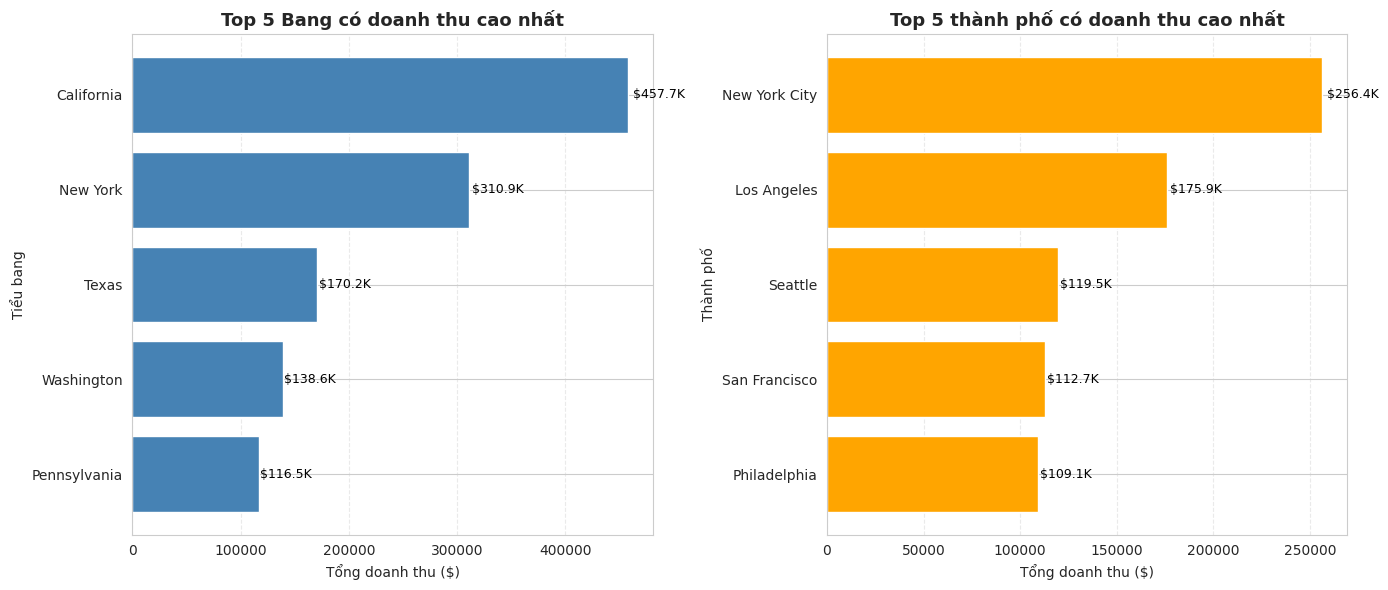

In [385]:
# Tạo khung 2 biểu đồ cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sắp xếp dữ liệu giảm dần
top_5_state = top_5_state.sort_values(by='sales', ascending=True)  # ngang, tăng từ dưới lên trên
top_5_city = top_5_city.sort_values(by='sales', ascending=True)

# --- Biểu đồ 1: Top 5 States (ngang) ---
axes[0].barh(top_5_state['state'], top_5_state['sales'], color='steelblue')
axes[0].set_title('Top 5 Bang có doanh thu cao nhất', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Tổng doanh thu ($)')
axes[0].set_ylabel('Tiểu bang')
axes[0].grid(axis='x', linestyle='--', alpha=0.4)

# Thêm label trên từng thanh ngang
for i, v in enumerate(top_5_state['sales']):
    axes[0].text(v + (v * 0.01), i, format_sales(v),
                 va='center', ha='left', fontsize=9, color='black')

# --- Biểu đồ 2: Top 5 Cities (ngang) ---
axes[1].barh(top_5_city['city'], top_5_city['sales'], color='orange')
axes[1].set_title('Top 5 thành phố có doanh thu cao nhất', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Tổng doanh thu ($)')
axes[1].set_ylabel('Thành phố')
axes[1].grid(axis='x', linestyle='--', alpha=0.4)

# Thêm label trên từng thanh ngang
for i, v in enumerate(top_5_city['sales']):
    axes[1].text(v + (v * 0.01), i, format_sales(v),
                 va='center', ha='left', fontsize=9, color='black')

# Căn chỉnh bố cục cho đẹp
plt.tight_layout()
plt.show()

**Mức lỗ theo các tiểu bang (State)**

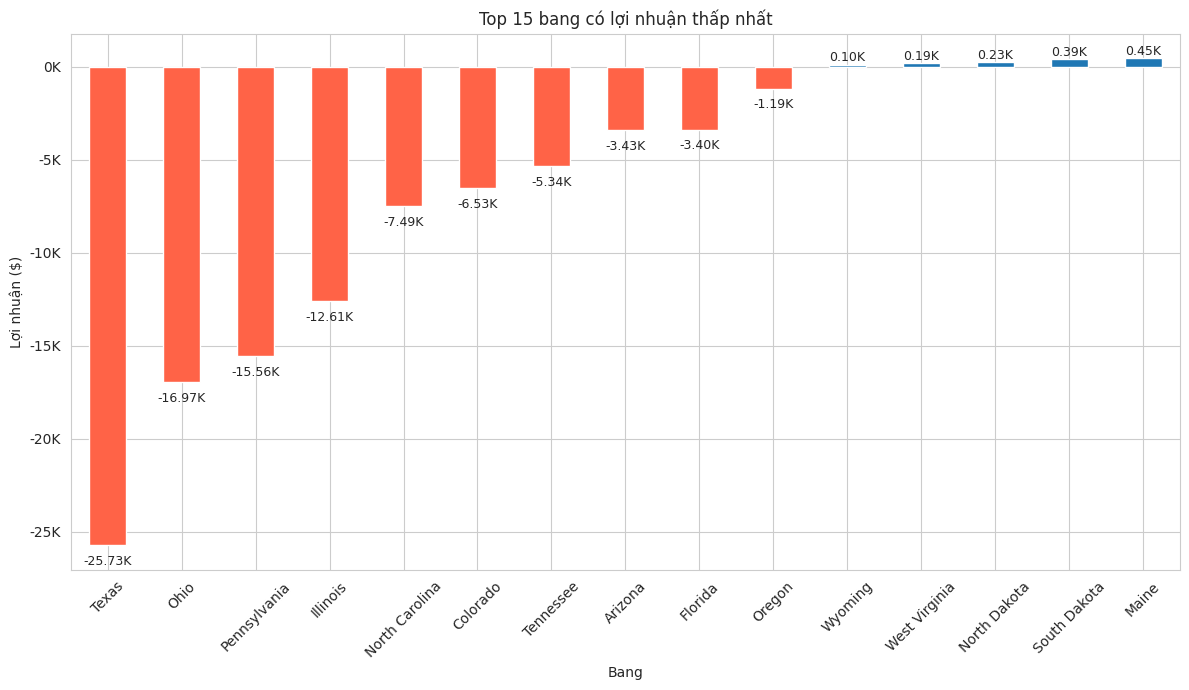

In [386]:
# Tạo danh sách lợi nhuận theo bang (tăng dần)
state_loss = df.groupby("state", observed=False)["profit"].sum().sort_values()

# Lấy 15 bang có lợi nhuận thấp nhất
least_profitable_states = state_loss.head(15)

# Tạo biểu đồ cột thể hiện 15 bang lỗ nhiều nhất
plt.figure(figsize=(12, 7))
colors = ["tomato" if val < 0 else "tab:blue" for val in least_profitable_states]
bars = least_profitable_states.plot(kind="bar", color=colors)

plt.title("Top 15 bang có lợi nhuận thấp nhất")
plt.xlabel("Bang")
plt.ylabel("Lợi nhuận ($)")
plt.xticks(rotation=45)

# Thêm nhãn giá trị lên từng cột
for i, value in enumerate(least_profitable_states):
    plt.text(i, value + (least_profitable_states.max()*0.05 if value > 0 else least_profitable_states.min()*0.02), f'{value/1000:.2f}K',
             ha='center', va='bottom' if value > 0 else 'top', fontsize=9)

# Định dạng trục tung theo đơn vị nghìn (K)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

plt.tight_layout()
plt.show()

NHẬN XÉT

Khi xem xét 5 bang có doanh số cao nhất, chúng ta thấy Texas - bang có lợi nhuận thấp thứ ba. Điều này có nghĩa là, mặc dù Texas có doanh số lớn, nhưng vẫn đang chịu lỗ. Tương tự như khu vực Trung tâm, nguyên nhân gây thua lỗ tại Texas có thể là do chính sách chiết khấu chưa hợp lý.


**Mức chiết khấu theo doanh số và nhóm sản phẩm tại Texas**

In [387]:
texas_df = df[df['state'] == 'Texas']

# Aggregate Sales, Profit and Avg Discount by Sub-Category
subcat_summary = texas_df.groupby('sub_category').agg({
    'sales':'sum',
    'profit':'sum',
    'discount':'mean'
}).reset_index()

/tmp/ipython-input-1528560802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subcat_summary = texas_df.groupby('sub_category').agg({


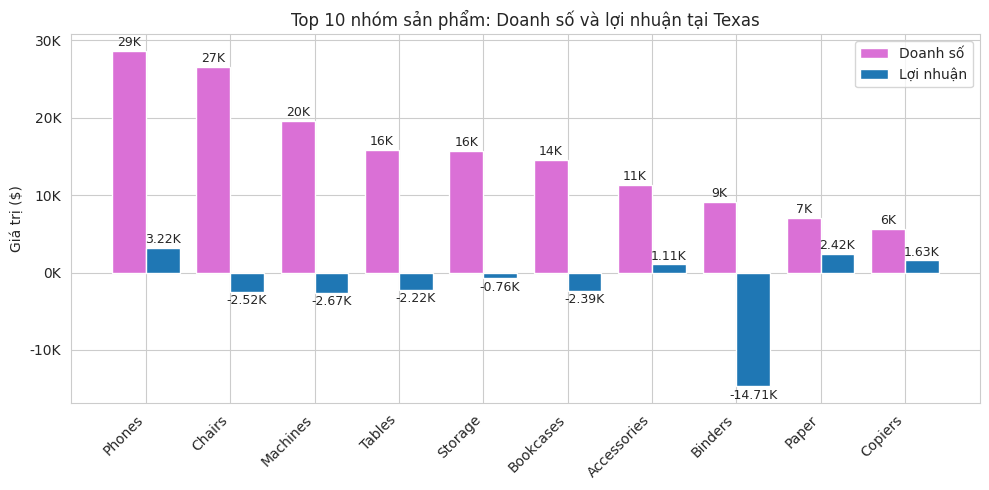

In [388]:
# --- Biểu đồ: So sánh doanh số và lợi nhuận theo nhóm sản phẩm tại Texas ---

x = top10_subcat['sub_category']
bar_width = 0.4
x_idx = range(len(x))

plt.figure(figsize=(10,5))

# Vẽ 2 cột cạnh nhau (Sales & Profit)
bars_sales = plt.bar([i - bar_width/2 for i in x_idx], top10_subcat['sales'],
                     width=bar_width, color='orchid', label='Doanh số')
bars_profit = plt.bar([i + bar_width/2 for i in x_idx], top10_subcat['profit'],
                      width=bar_width, color='tab:blue', label='Lợi nhuận')

# Cài đặt trục và nhãn
plt.xticks(x_idx, x, rotation=45, ha='right')
plt.ylabel("Giá trị ($)")
plt.title("Top 10 nhóm sản phẩm: Doanh số và lợi nhuận tại Texas")
plt.legend()

# Định dạng trục tung theo đơn vị nghìn
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Thêm label trên cột Doanh số
for bar in bars_sales:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + max(top10_subcat['sales'])*0.01,
        f'{height/1000:.0f}K',ha='center',va='bottom',fontsize=9
    )

# Thêm label trên cột Lợi nhuận
for i, value in enumerate(top10_subcat['profit']):
    plt.text(
        i + bar_width/2,  # vị trí cột lợi nhuận (giống vị trí vẽ thanh)
        value + (top10_subcat['profit'].max()*0.05 if value > 0 else top10_subcat['profit'].min()*0.02),
        f'{value/1000:.2f}K',
        ha='center',
        va='bottom' if value > 0 else 'top',
        fontsize=9
    )

plt.tight_layout()
plt.show()


/tmp/ipython-input-822183048.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top10_subcat = (texas_df.groupby('sub_category')


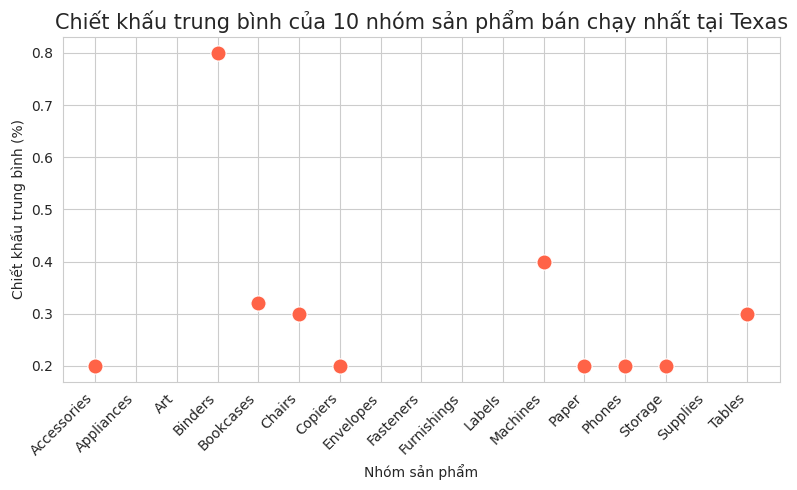

In [389]:
# --- Biểu đồ scatter: Chiết khấu trung bình của 10 nhóm sản phẩm bán chạy nhất tại Texas ---

# top 10 Sub-Categories by Sales
top10_subcat = (texas_df.groupby('sub_category')
    .agg({'sales': 'sum', 'profit': 'sum', 'discount': 'mean'})
    .reset_index()
    .sort_values(by='sales', ascending=False)
    .head(10))

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=top10_subcat,
    x='sub_category',
    y='discount',
    s=120,
    color='tomato'
)

plt.title("Chiết khấu trung bình của 10 nhóm sản phẩm bán chạy nhất tại Texas", fontsize=15)
plt.xlabel("Nhóm sản phẩm")
plt.ylabel("Chiết khấu trung bình (%)")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Khi xem xét các biểu đồ cùng nhau, ta có thể hiểu rõ hơn lý do tại sao bang Texas — mặc dù có *doanh số đứng thứ ba* toàn quốc nhưng lại là bang có *lợi nhuận thấp nhất*.

* Top 10 nhóm sản phẩm theo Doanh số và Lợi nhuận tại Texas:
Gần như toàn bộ các nhóm sản phẩm bán chạy nhất ở Texas đều có lợi nhuận âm, nghĩa là những sản phẩm đều mang lại doanh thu cao thực chất lại đang gây thua lỗ.

* Chiết khấu trung bình của Top 10 nhóm sản phẩm tại Texas:
Phần lớn các nhóm sản phẩm bị lỗ đều có mức chiết khấu trung bình cao, trong đó nhóm thua lỗ nặng nhất cũng là nhóm có chiết khấu cao nhất.

KẾT LUẬN:
Nguyên nhân chính khiến Texas có lợi nhuận thấp, dù doanh số mạnh, là do chính sách giảm giá quá mạnh đối với các sản phẩm bán chạy.
Mức chiết khấu cao đã làm giảm biên lợi nhuận, khiến doanh số tăng nhưng lợi nhuận tổng thể lại sụt giảm đáng kể.

### 3.6. Phân tích theo danh mục sản phẩm (Category)

In [390]:
# So sánh hiệu quả kinh doanh giữa các danh mục sản phẩm
sales_furniture = df.loc[df['category']=='Furniture','sales'].sum()
sales_office = df.loc[df['category']=='Office Supplies','sales'].sum()
sales_technology = df.loc[df['category']=='Technology','sales'].sum()

print('Doanh số - Nội thất:', sales_furniture)
print('Doanh số - Văn phòng phẩm:', sales_office)
print('Doanh số - Công nghệ:', sales_technology)

profit_furniture=df.loc[df['category']=='Furniture','profit'].sum()
profit_office=df.loc[df['category']=='Office Supplies','profit'].sum()
profit_technology=df.loc[df['category']=='Technology','profit'].sum()

print(20*'-')

print('Lợi nhuận - Nội thất:', profit_furniture)
print('Lợi nhuận - Văn phòng phẩm:', profit_office)
print('Lợi nhuận - Công nghệ:', profit_technology)

Doanh số - Nội thất: 741999.7953
Doanh số - Văn phòng phẩm: 719047.032
Doanh số - Công nghệ: 836154.033
--------------------
Lợi nhuận - Nội thất: 18451.272800000006
Lợi nhuận - Văn phòng phẩm: 122490.8008
Lợi nhuận - Công nghệ: 145454.9481


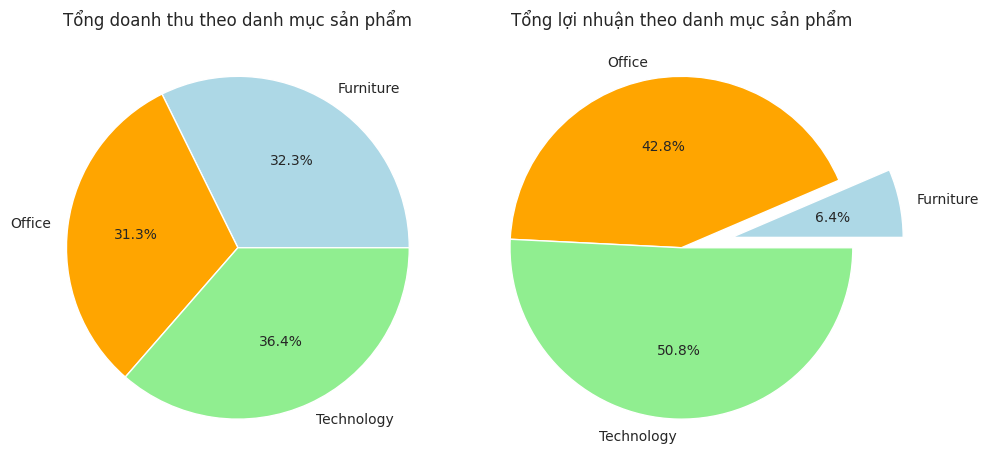

In [391]:
# --- Biểu đồ: Tổng doanh thu và lợi nhuận theo danh mục sản phẩm ---

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = ['lightblue', 'orange', 'lightgreen']

# --- Biểu đồ 1: Tổng doanh thu theo danh mục ---
ax[0].pie(
    [sales_furniture, sales_office, sales_technology],
    labels=['Furniture', 'Office', 'Technology'],
    colors=colors,
    autopct='%1.1f%%'
)
ax[0].set_title('Tổng doanh thu theo danh mục sản phẩm')

# --- Biểu đồ 2: Tổng lợi nhuận theo danh mục ---
ax[1].pie(
    [profit_furniture, profit_office, profit_technology],
    labels=['Furniture', 'Office', 'Technology'],
    colors=colors,
    autopct='%1.1f%%',
    explode=[0.3, 0, 0]
)
ax[1].set_title('Tổng lợi nhuận theo danh mục sản phẩm')
plt.tight_layout()
plt.show()


**Biên lợi nhuận theo từng danh mục**

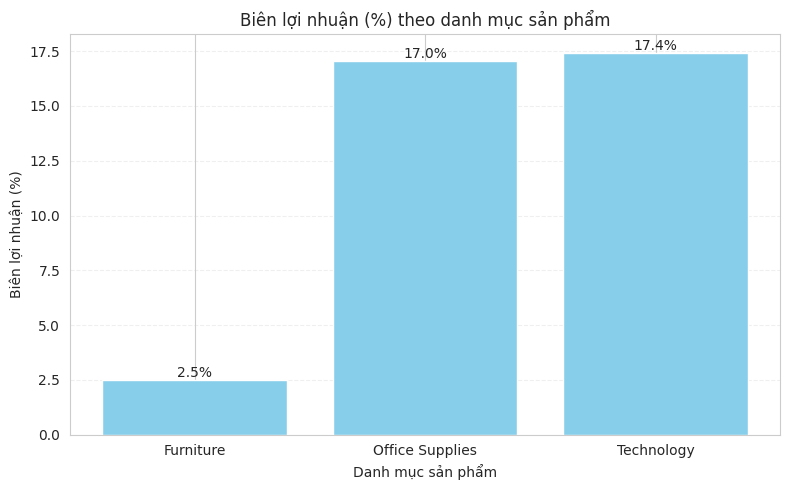

In [392]:
# --- Tính Profit Margin (%) theo Category ---
category_profit = df.groupby('category', observed=False)[['sales', 'profit']].sum().reset_index()
category_profit['Profit Margin (%)'] = (category_profit['profit'] / category_profit['sales']) * 100

# --- Vẽ biểu đồ ---
plt.figure(figsize=(8,5))
bars = plt.bar(category_profit['category'], category_profit['Profit Margin (%)'], color='skyblue')
plt.title('Biên lợi nhuận (%) theo danh mục sản phẩm')
plt.xlabel('Danh mục sản phẩm')
plt.ylabel('Biên lợi nhuận (%)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width()/2,
        y=height,
        s=f'{height:.1f}%', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

NHẬN XÉT
* Danh mục có ít lợi nhuận nhất là Đồ nội thất (Furniture).

**Danh mục nào mang lại doanh thu cao nhất/thấp nhất trên từng khu vực?**

/tmp/ipython-input-416879880.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_category_sales = df.groupby(['region', 'category'])['sales'].sum().reset_index()
/tmp/ipython-input-416879880.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_sales = region_category_sales.loc[region_category_sales.groupby('region')['sales'].idxmax()]
/tmp/ipython-input-416879880.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

Danh mục có DOANH THU CAO NHẤT trên từng khu vực:
    region    category        sales
2  Central  Technology   170416.312
5     East  Technology   264973.981
8    South  Technology   148771.908
9     West   Furniture  252612.7435

 Danh mục có DOANH THU THẤP NHẤT trên từng khu vực:
     region         category        sales
0   Central        Furniture  163797.1638
4      East  Office Supplies   205516.055
6     South        Furniture   117298.684
10     West  Office Supplies   220853.249


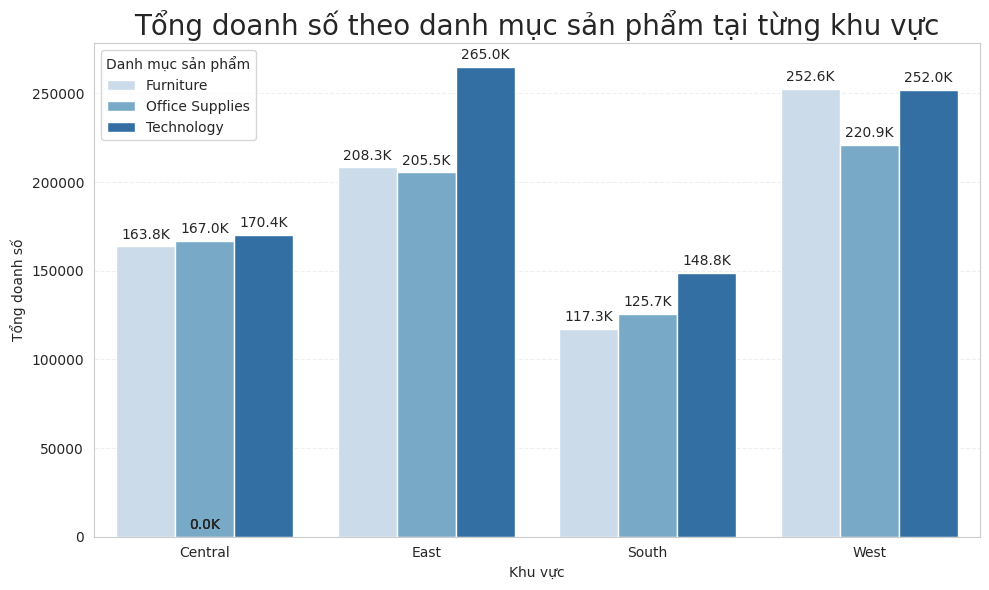

In [393]:
# Tính tổng doanh thu theo khu vực và danh mục
region_category_sales = df.groupby(['region', 'category'])['sales'].sum().reset_index()
# Tìm danh mục có doanh thu cao nhất / thấp nhất trên mỗi khu vực
max_sales = region_category_sales.loc[region_category_sales.groupby('region')['sales'].idxmax()]
min_sales = region_category_sales.loc[region_category_sales.groupby('region')['sales'].idxmin()]

print("Danh mục có DOANH THU CAO NHẤT trên từng khu vực:")
print(max_sales)
print("\n Danh mục có DOANH THU THẤP NHẤT trên từng khu vực:")
print(min_sales)

# --- Biểu đồ ---
plt.figure(figsize=(10,6))
ax = sns.barplot(data=region_category_sales, x='region', y='sales', hue='category', palette='Blues')
plt.title('Tổng doanh số theo danh mục sản phẩm tại từng khu vực', fontsize=20)
plt.ylabel('Tổng doanh số')
plt.xlabel('Khu vực')
plt.legend(title='Danh mục sản phẩm')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height + max(region_category_sales['sales'])*0.01,
        s=f'{height/1000:.1f}K',ha='center',va='bottom',fontsize=10
    )

plt.tight_layout()
plt.show()

**Tại sao đồ nội thất (Furniture) mang lại doanh thu khá cao gần bằng 2 nhóm hàng còn lại nhưng lợi nhuận có được lại rất thấp?**

**Lợi nhuận theo các tiểu mục (sub-category)**

/tmp/ipython-input-3977166176.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=profit_subcat, x='sub_category', y='profit',
/tmp/ipython-input-3977166176.py:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=profit_subcat, x='sub_category', y='profit',


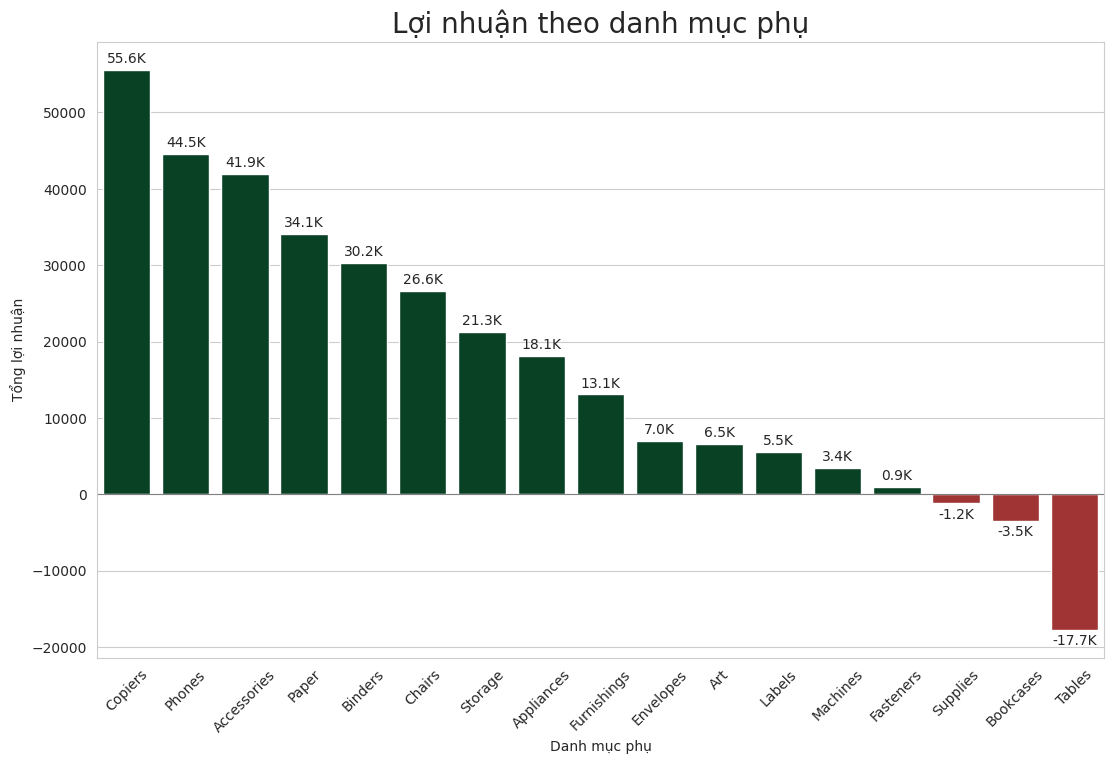

Top 3 danh mục phụ có lợi nhuận cao nhất:
   sub_category      profit
6       Copiers  55617.8249
13       Phones  44515.7306
0   Accessories  41936.6357

Top 3 danh mục phụ có lợi nhuận thấp nhất:
   sub_category      profit
16       Tables -17725.4811
4     Bookcases   -3472.556
15     Supplies  -1189.0995


In [394]:
# Tính toán lợi nhuận
profit_subcat = df.groupby("sub_category", observed=True)["profit"].sum().reset_index().sort_values(by="profit", ascending=False)

order_list = profit_subcat['sub_category']

# --- Biểu đồ: Tổng lợi nhuận theo nhóm hàng phụ ---
import matplotlib.colors as mcolors

plt.figure(figsize=(13,8))

rgb_color_tuple = sns.color_palette("ocean", as_cmap=False)[0]
color_positive_hex = mcolors.to_hex(rgb_color_tuple)
color_negative = "firebrick"
bar_colors = np.where(
    profit_subcat['profit'] >= 0,
    color_positive_hex,
    color_negative
)

ax = sns.barplot(data=profit_subcat, x='sub_category', y='profit',
            order=order_list, palette = bar_colors)
plt.xticks(rotation=45)
plt.title('Lợi nhuận theo danh mục phụ', fontsize=20)
plt.xlabel('Danh mục phụ',fontsize=10)
plt.ylabel('Tổng lợi nhuận',fontsize=10)
plt.axhline(0, color='grey', linewidth=0.8)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height + np.sign(height)*max(abs(profit_subcat['profit']))*0.01,
        s=f'{height/1000:.1f}K',
        ha='center',
        va='bottom' if height >= 0 else 'top',
        fontsize=10
    )
plt.show()

# --- Top 3 danh mục phụ có lợi nhuận cao nhất ---
top3_high_profit = profit_subcat.sort_values(by='profit', ascending=False).head(3)
print("Top 3 danh mục phụ có lợi nhuận cao nhất:")
print(top3_high_profit)

# --- Top 3 danh mục phụ có lợi nhuận thấp nhất ---
top3_low_profit = profit_subcat.sort_values(by='profit', ascending=True).head(3)
print("\nTop 3 danh mục phụ có lợi nhuận thấp nhất:")
print(top3_low_profit)

NHẬN XÉT

🔹 Top 3 nhóm có lợi nhuận cao nhất:

* Copiers (Máy photocopy) đạt lợi nhuận cao nhất, hơn 55.000 USD, cho thấy đây là sản phẩm mang lại giá trị kinh tế lớn, có thể nhờ biên lợi nhuận cao hoặc nhu cầu ổn định.

* Phones (Điện thoại) và Accessories (Phụ kiện) cũng có lợi nhuận tốt, lần lượt khoảng 44.500 USD và 41.900 USD, chứng tỏ nhóm sản phẩm công nghệ và văn phòng là nguồn lợi nhuận chính.

🔻 Top 3 nhóm có lợi nhuận thấp nhất:

* Tables (Bàn) gây lỗ nặng nhất, gần –17.700 USD, cho thấy khả năng định giá, chiết khấu hoặc chi phí vận chuyển/sản xuất có vấn đề.

* Bookcases (Giá sách) và Supplies (Vật tư) cũng ghi nhận lỗ nhẹ, dưới –3.500 USD, tuy không nghiêm trọng bằng nhưng vẫn cần xem xét để cải thiện.

**KẾT LUẬN:**
Doanh nghiệp đang phụ thuộc phần lớn vào nhóm sản phẩm công nghệ (Copiers, Phones, Accessories) để tạo lợi nhuận, trong khi nhóm nội thất (Tables, Bookcases) lại là điểm yếu cần được đánh giá lại về giá bán, chiết khấu hoặc cấu trúc chi phí.

**Chiết khấu theo tiểu mục (Sub-Category)**

/tmp/ipython-input-2271932002.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("sub_category")[["discount", "sales"]]


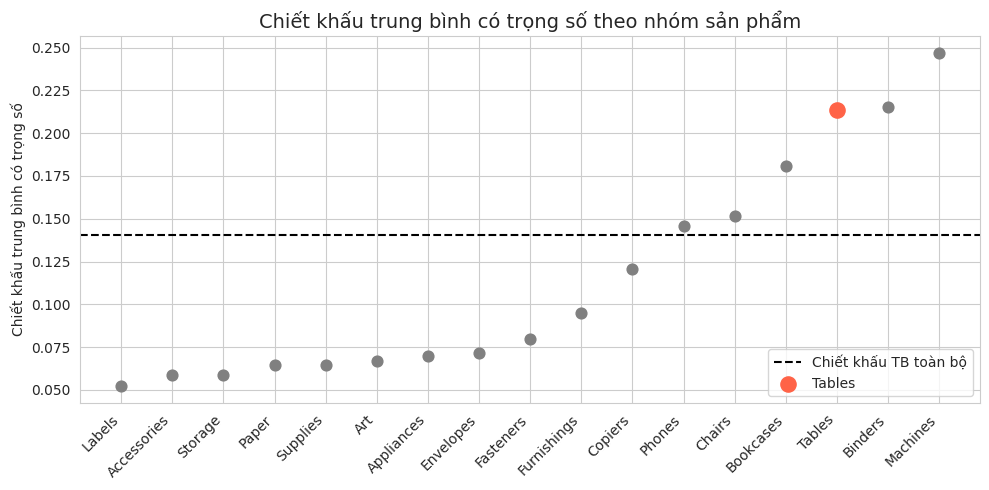

In [395]:
# --- Biểu đồ: So sánh chiết khấu trung bình có trọng số theo nhóm sản phẩm ---

# Tính chiết khấu trung bình có trọng số (theo doanh số) cho từng nhóm sản phẩm
weighted_discount = (
    df.groupby("sub_category")[["discount", "sales"]]
    .apply(lambda x: (x["discount"] * x["sales"]).sum() / x["sales"].sum())
    .sort_values()
)

# Tính chiết khấu trung bình có trọng số cho toàn bộ sản phẩm
overall_weighted_avg = (df["discount"] * df["sales"]).sum() / df["sales"].sum()

# Vẽ biểu đồ
plt.figure(figsize=(10,5))

# Đường gạch ngang biểu thị chiết khấu trung bình toàn bộ
plt.axhline(overall_weighted_avg, color='black', linestyle='--', label='Chiết khấu TB toàn bộ')

# Các điểm biểu diễn chiết khấu từng nhóm sản phẩm
plt.scatter(weighted_discount.index, weighted_discount.values, color='gray', s=60)

# Tô đỏ nhóm “Tables” để làm nổi bật
plt.scatter('Tables', weighted_discount['Tables'], color='tomato', s=120, label='Tables')

# Cài đặt biểu đồ
plt.title("Chiết khấu trung bình có trọng số theo nhóm sản phẩm", fontsize=14)
plt.ylabel("Chiết khấu trung bình có trọng số")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


NHẬN XÉT

* Biểu đồ củng cố nhận định rằng chính sách chiết khấu quá cao đối với nhóm **Tables** là nguyên nhân trực tiếp khiến nhóm này bị lỗ. Doanh nghiệp cần xem xét lại chiến lược giá hoặc chính sách khuyến mãi cho sản phẩm này để cải thiện hiệu quả kinh doanh.

### 3.7. Theo chiết khấu và hiệu quả đơn hàng

**Khi chiết khấu lớn hơn 20% (discount > 0.2), tỉ lệ đơn hàng lỗ tăng mạnh không?**

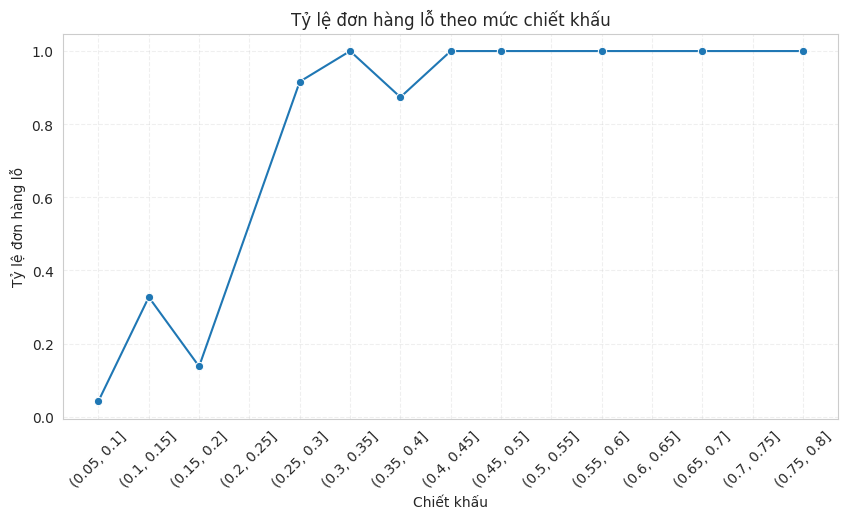

In [396]:
# Thêm cột order_loss: 1 nếu profit < 0, 0 nếu profit >=0
df['order_loss'] = (df['profit'] < 0).astype(int)

# Nhóm theo bins của discount để dễ quan sát xu hướng
discount_bins = np.arange(0, df['discount'].max() + 0.05, 0.05)  # chia discount mỗi 5%
df['discount_bin'] = pd.cut(df['discount'], bins=discount_bins)

# Tính tỷ lệ đơn hàng lỗ trong mỗi bin
loss_rate = df.groupby('discount_bin', observed=False)['order_loss'].mean().reset_index()

# Convert the discount_bin to string for plotting
loss_rate['discount_bin'] = loss_rate['discount_bin'].astype(str)

# Vẽ biểu đồ
plt.figure(figsize=(10,5))
sns.lineplot(x='discount_bin', y='order_loss', data=loss_rate, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Chiết khấu')
plt.ylabel('Tỷ lệ đơn hàng lỗ')
plt.title('Tỷ lệ đơn hàng lỗ theo mức chiết khấu')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

NHẬN XÉT
* Khi mức chiết khấu dưới 0.2, tỷ lệ đơn hàng lỗ còn thấp, dao động quanh khúc 0–30%, nghĩa là phần lớn các đơn hàng ở mức giảm giá nhẹ vẫn có lợi nhuận.

* Tuy nhiên, từ mức chiết khấu 0.25 trở lên, tỷ lệ đơn hàng lỗ tăng mạnh, vượt 90%, và đạt 100% ở nhiều khoảng chiết khấu cao hơn (từ 0.3 trở đi).

* Điều này cho thấy mức giảm giá càng cao thì khả năng thua lỗ càng lớn, đặc biệt khi chiết khấu vượt quá 25%.

**Kết luận:**
Biểu đồ khẳng định rằng chiết khấu là yếu tố ảnh hưởng trực tiếp đến lợi nhuận.
Chính sách giảm giá quá sâu (trên 25%) gần như đảm bảo thua lỗ, do giá bán không đủ bù đắp chi phí. Doanh nghiệp nên kiểm soát ngưỡng chiết khấu, chỉ áp dụng giảm giá lớn cho sản phẩm có biên lợi nhuận cao hoặc cần xả hàng tồn

**Biên lợi nhuận trung bình theo discount**
- Có ngưỡng chiết khấu nào làm biên lợi nhuận giảm sâu?

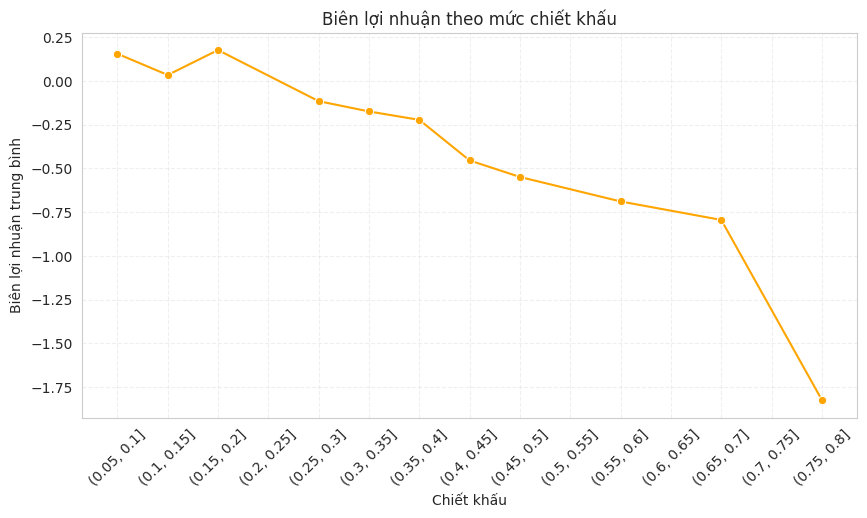

In [397]:
# Tính biên lợi nhuận = profit / sales
df['profit_margin'] = df['profit'] / df['sales']

# Trung bình biên lợi nhuận theo bin discount
margin_by_discount = df.groupby('discount_bin', observed=False)['profit_margin'].mean().reset_index()

# Convert the discount_bin to string for plotting
margin_by_discount['discount_bin'] = margin_by_discount['discount_bin'].astype(str)

# Vẽ biểu đồ
plt.figure(figsize=(10,5))
sns.lineplot(x='discount_bin', y='profit_margin', data=margin_by_discount, marker='o', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Chiết khấu')
plt.ylabel('Biên lợi nhuận trung bình')
plt.title('Biên lợi nhuận theo mức chiết khấu')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

NHẬN XÉT

* Biểu đồ cho thấy chiết khấu càng cao thì biên lợi nhuận càng giảm rõ rệt. có thể thấy ở mức chiết khấu thấp (dưới 0.2), biên lợi nhuận vẫn dương, tức là doanh nghiệp vẫn đạt lãi nhẹ
* Khi chiết khấu vượt 20–25%, lợi nhuận bắt đầu âm và giảm sâu mạnh ở mức trên 0.6

Đính hướng doanh nghiệp nên giới hạn mức chiết khấu, tối ưu chiến lược khuyến mãi - thay vì giảm giá trực tiếp, có thể áp dụng quà tặng hoặc gói dịch vụ giá trị gia tăng để bảo toàn lợi nhuận

### 3.8. Phân tích theo phân khúc khách hàng

**Phân khúc khách hàng nào chiếm tỷ trọng lớn**

In [398]:
# Tính tổng doanh thu theo phân khúc khách hàng
segment_sales = df.groupby('segment')['sales'].sum().reset_index()

# Tính tỷ trọng (%)
segment_sales['sales_pct'] = 100 * segment_sales['sales'] / segment_sales['sales'].sum()

# Sắp xếp giảm dần để biết phân khúc chiếm tỷ trọng lớn nhất
segment_sales = segment_sales.sort_values(by='sales', ascending=False)

print("Tỷ trọng doanh thu theo phân khúc khách hàng:")
print(segment_sales)


Tỷ trọng doanh thu theo phân khúc khách hàng:
       segment        sales  sales_pct
0     Consumer  1161401.345   50.55724
1    Corporate  706146.3668  30.739426
2  Home Office  429653.1485  18.703334


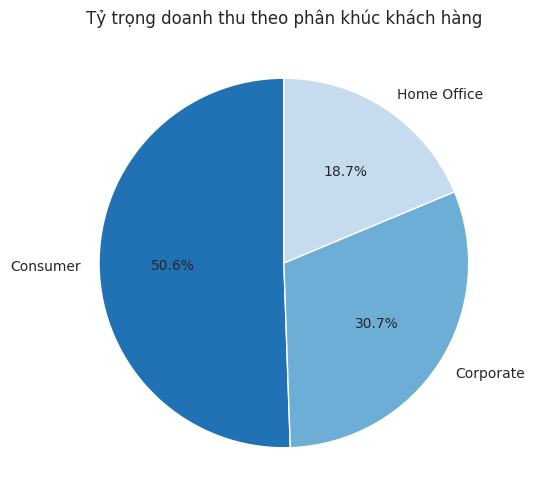

In [399]:
segment_sales = df.groupby('segment')['sales'].sum().reset_index()
segment_sales['sales_pct'] = 100 * segment_sales['sales'] / segment_sales['sales'].sum()
segment_sales = segment_sales.sort_values(by='sales', ascending=False)

# --- Vẽ pie chart ---
plt.figure(figsize=(6,6))
colors = sns.color_palette('Blues_r', len(segment_sales))
plt.pie(segment_sales['sales_pct'], labels=segment_sales['segment'],
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Tỷ trọng doanh thu theo phân khúc khách hàng')
plt.show()

**Top 10 khách hàng đóng góp doanh thu / lợi nhuận cao nhất**

In [400]:
# Top 10 khách hàng theo doanh thu
top10_customers_sales = df.groupby('customer_name')['sales'].sum().sort_values(ascending=False).head(10)
print("Top 10 khách hàng theo doanh thu:")
print(top10_customers_sales)

# Top 10 khách hàng theo lợi nhuận
top10_customers_profit = df.groupby('customer_name')['profit'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 khách hàng theo lợi nhuận:")
print(top10_customers_profit)


Top 10 khách hàng theo doanh thu:
customer_name
Sean Miller            25043.05
Tamara Chand          19052.218
Raymond Buch          15117.339
Tom Ashbrook           14595.62
Adrian Barton         14473.571
Ken Lonsdale          14175.229
Sanjit Chand          14142.334
Hunter Lopez          12873.298
Sanjit Engle          12209.438
Christopher Conant    12129.072
Name: sales, dtype: Float64

Top 10 khách hàng theo lợi nhuận:
customer_name
Tamara Chand            8981.3239
Raymond Buch            6976.0959
Sanjit Chand            5757.4119
Hunter Lopez            5622.4292
Adrian Barton           5444.8055
Tom Ashbrook            4703.7883
Christopher Martinez    3899.8904
Keith Dawkins           3038.6254
Andy Reiter             2884.6208
Daniel Raglin            2869.076
Name: profit, dtype: Float64


/tmp/ipython-input-1618286537.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales', y='customer_name', data=top10_customers_sales, palette='Greens_r', ax=axes[0])
/tmp/ipython-input-1618286537.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='profit', y='customer_name', data=top10_customers_profit, palette='Oranges_r', ax=axes[1])


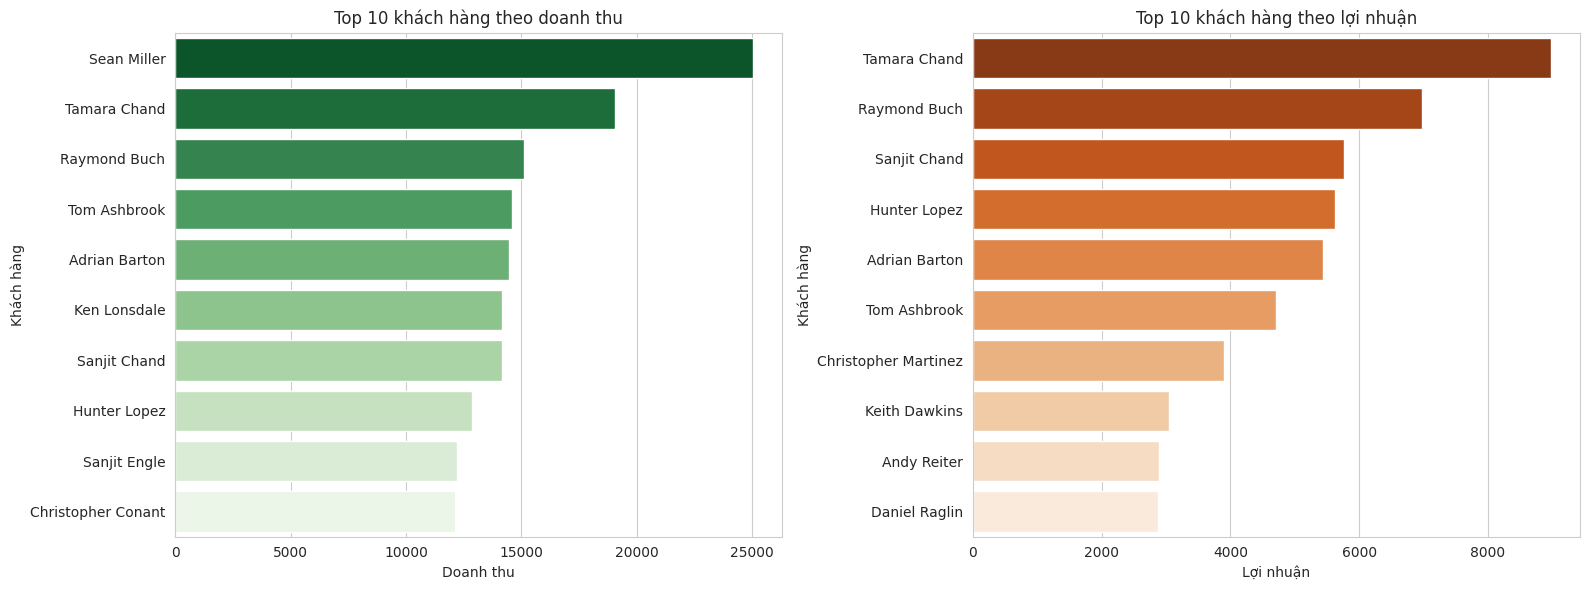

In [401]:
top10_customers_sales = df.groupby('customer_name')['sales'].sum().sort_values(ascending=False).head(10).reset_index()
top10_customers_profit = df.groupby('customer_name')['profit'].sum().sort_values(ascending=False).head(10).reset_index()

# --- Vẽ biểu đồ ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Biểu đồ 1: Top 10 khách hàng theo doanh thu
sns.barplot(x='sales', y='customer_name', data=top10_customers_sales, palette='Greens_r', ax=axes[0])
axes[0].set_title('Top 10 khách hàng theo doanh thu')
axes[0].set_xlabel('Doanh thu')
axes[0].set_ylabel('Khách hàng')

# Biểu đồ 2: Top 10 khách hàng theo lợi nhuận
sns.barplot(x='profit', y='customer_name', data=top10_customers_profit, palette='Oranges_r', ax=axes[1])
axes[1].set_title('Top 10 khách hàng theo lợi nhuận')
axes[1].set_xlabel('Lợi nhuận')
axes[1].set_ylabel('Khách hàng')

plt.tight_layout()
plt.show()

**Hành vi mua hàng**

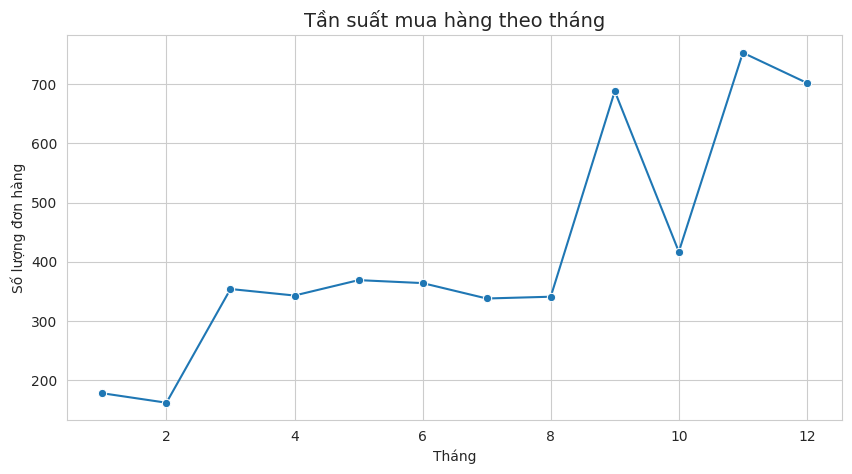

In [402]:
# Phân tích thời điểm mua hàng (theo tháng)
monthly_orders = df.groupby('month_order')['order_id'].nunique()
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_orders.index, y=monthly_orders.values, marker='o')
plt.title('Tần suất mua hàng theo tháng', fontsize=14)
plt.xlabel('Tháng')
plt.ylabel('Số lượng đơn hàng')
plt.grid(True)
plt.show()


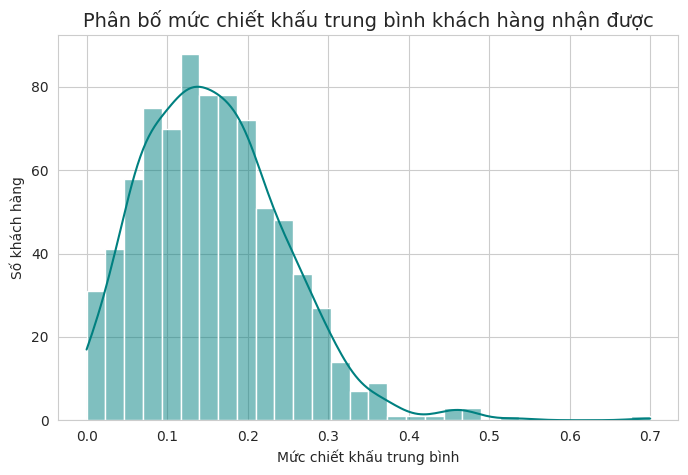

In [403]:
# Phân tích mức chiết khấu ưa thích của khách hàng
discount_pref = df.groupby('customer_id')['discount'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.histplot(discount_pref['discount'], bins=30, kde=True, color='teal')
plt.title('Phân bố mức chiết khấu trung bình khách hàng nhận được', fontsize=14)
plt.xlabel('Mức chiết khấu trung bình')
plt.ylabel('Số khách hàng')
plt.show()

### 3.9. Phân tích theo logistic (Ship Mode / Shipping Time)

**Ship Mode nào phổ biến nhất?**

In [404]:
shipmode_count = df['ship_mode'].value_counts().reset_index()
shipmode_count.columns = ['ship_mode', 'order_count']

print("Số lượng đơn hàng theo Ship Mode:")
print(shipmode_count)

Số lượng đơn hàng theo Ship Mode:
        ship_mode  order_count
0  Standard Class         5968
1    Second Class         1945
2     First Class         1538
3        Same Day          543


/tmp/ipython-input-3297682466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ship_mode', y='order_count', data=shipmode_count, palette='Blues_r')


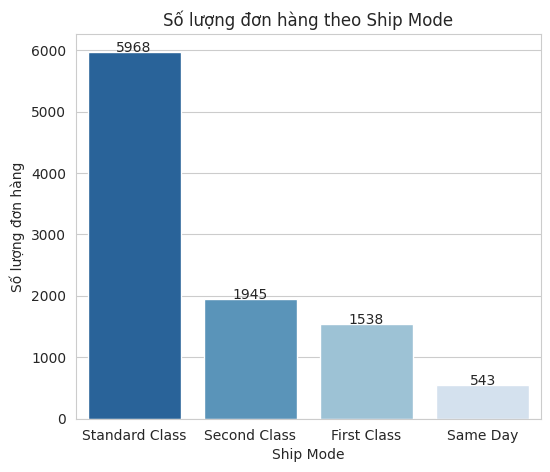

In [405]:
plt.figure(figsize=(6,5))
ax = sns.barplot(x='ship_mode', y='order_count', data=shipmode_count, palette='Blues_r')
plt.title('Số lượng đơn hàng theo Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Số lượng đơn hàng')
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2,
            y=height + 1,
            s=int(height), ha='center')
plt.show()

**Ship Mode có thời gian giao hàng trung bình nhanh nhất?**

In [406]:
avg_shipping_time = df.groupby('ship_mode')['shipping_time'].mean().reset_index().sort_values(by='shipping_time')

print("Thời gian giao hàng trung bình theo Ship Mode:")
print(avg_shipping_time)

Thời gian giao hàng trung bình theo Ship Mode:
        ship_mode  shipping_time
1        Same Day       0.044199
0     First Class       2.182705
2    Second Class       3.238046
3  Standard Class       5.006535


/tmp/ipython-input-2922676432.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ship_mode', y='shipping_time', data=avg_shipping_time, palette='Blues_r')


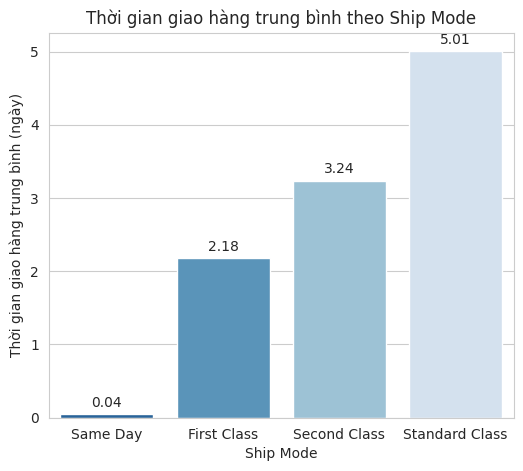

In [407]:
plt.figure(figsize=(6,5))
ax = sns.barplot(x='ship_mode', y='shipping_time', data=avg_shipping_time, palette='Blues_r')
plt.title('Thời gian giao hàng trung bình theo Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Thời gian giao hàng trung bình (ngày)')
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2,
            y=height + 0.1,
            s=f'{height:.2f}', ha='center')
plt.show()

### 3.10. Hệ số tương quan giữa các yếu tố

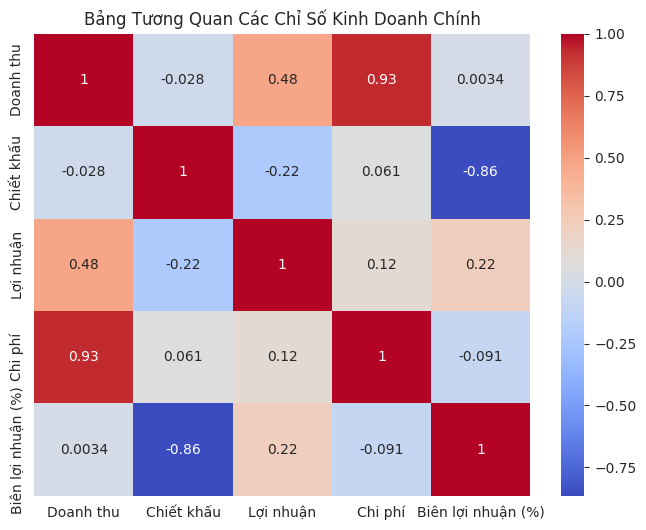

In [408]:
# Đặt tên cột dễ nhìn
df_rename = df.rename(columns={
    'sales': 'Doanh thu',
    'discount': 'Chiết khấu',
    'profit': 'Lợi nhuận',
    'cost': 'Chi phí',
    'profit_margin': 'Biên lợi nhuận (%)'
})

numeric_col_rename = ['Doanh thu', 'Chiết khấu', 'Lợi nhuận', 'Chi phí', 'Biên lợi nhuận (%)']
corr_matrix = df_rename[numeric_col_rename].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Bảng Tương Quan Các Chỉ Số Kinh Doanh Chính')
plt.show()


NHẬN XÉT

Biểu đồ tương quan cho thấy một số mối quan hệ đáng chú ý giữa các chỉ số kinh doanh:

* Doanh thu (Sales) và Chi phí (Cost) có mối tương quan rất cao (0.93), cho thấy khi doanh thu tăng thì chi phí cũng tăng tương ứng — phản ánh quy mô hoạt động mở rộng.

* Chiết khấu (Discount) và Biên lợi nhuận (Profit Margin %) có tương quan âm mạnh (-0.86), chứng tỏ chiết khấu cao làm giảm mạnh biên lợi nhuận.

* Doanh thu (Sales) và Lợi nhuận (Profit) có tương quan dương vừa phải (0.48), nghĩa là tăng doanh thu không luôn đồng nghĩa với tăng lợi nhuận — có thể do ảnh hưởng của chiết khấu hoặc chi phí.

* Discount – Profit: Tương quan âm yếu (-0.22) — chiết khấu cao làm giảm lợi nhuận đáng kể.

**Kết luận:** Việc tăng chiết khấu để đẩy doanh thu có thể làm giảm lợi nhuận biên, do đó doanh nghiệp cần cân đối giữa tăng trưởng doanh thu và duy trì lợi nhuận.

### 3.11. Dự báo doanh thu




/tmp/ipython-input-3017048908.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='order_date', freq='M'))['sales']


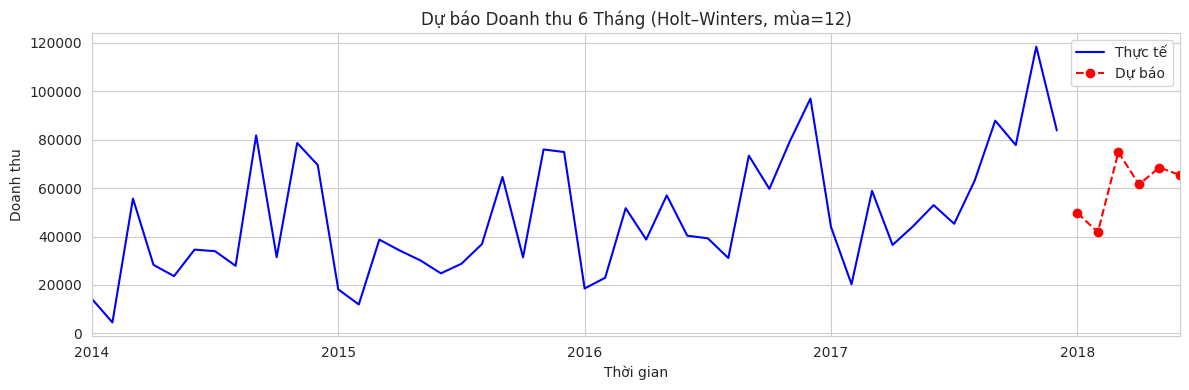

In [409]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Tạo bảng doanh thu theo tháng
monthly_sales = (
    df.groupby(pd.Grouper(key='order_date', freq='M'))['sales']
    .sum()
    .reset_index()
)
monthly_sales.rename(columns={'order_date': 'Date'}, inplace=True)

# 2️⃣ Chuyển 'Date' sang datetime và đặt làm index
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Date'])
y_series = monthly_sales.set_index('Date')['sales'].asfreq('ME').fillna(0)

# 3️⃣ Tạo mô hình Holt-Winters (chu kỳ mùa vụ 12 tháng)
hw = ExponentialSmoothing(y_series, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw.fit()

# 4️⃣ Dự báo 6 tháng tiếp theo
fcast_vals = hw_fit.forecast(6)
future_idx = pd.date_range(y_series.index[-1] + pd.offsets.MonthEnd(1), periods=6, freq='ME')
fcast = pd.Series(fcast_vals, index=future_idx)

# 5️⃣ Vẽ biểu đồ thực tế và dự báo
plt.figure(figsize=(12,4))
y_series.plot(label='Thực tế', color='blue')
fcast.plot(label='Dự báo', color='red', linestyle='--', marker='o')
plt.legend()
plt.title('Dự báo Doanh thu 6 Tháng (Holt–Winters, mùa=12)')
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.tight_layout()
plt.show()


NHẬN XÉT
* Doanh thu có tính mùa vụ rõ, thường tăng mạnh vào cuối năm.

* Dự báo 6 tháng tới doanh thu tăng nhẹ nhưng không bứt phá, nên cần chuẩn bị sớm cho mùa cao điểm.

* Doanh nghiệp nên quản lý hàng tồn kho chặt chẽ hơn, tránh để hàng ứ khi nhu cầu giảm.

* Tập trung marketing trước mùa mua sắm, giúp tận dụng tối đa giai đoạn doanh thu cao.

* Nên mở rộng sản phẩm hoặc khu vực bán hàng mới để giảm phụ thuộc vào mùa vụ và giữ doanh thu ổn định quanh năm.

### 3.12. Kiểm định giả thuyết

**Kiểm định: Doanh số trung bình của giao hàng hạng chuẩn và giao hàng hạng hai bằng nhau**

* Giả thuyết: Doanh số trung bình bằng nhau

H0: μ_standard = μ_second

* Đối thuyết: Doanh số trung bình khác nhau đáng kể

H1: μ_standard ≠ μ_second

In [410]:
from scipy.stats import ttest_ind

mode_a = 'Standard Class'
mode_b = 'Second Class'

# Filter sales data for A and B groups
sales_mode_a = df[df['ship_mode'] == mode_a]['sales']
sales_mode_b = df[df['ship_mode'] == mode_b]['sales']

# Calculate descriptive statistics for A/B Test context
print("=== So sánh doanh thu giữa hai hình thức giao hàng ===")
print(f"Group A ({mode_a}) Doanh thu trung bình: {sales_mode_a.mean():.2f} |Số đơn:{len(sales_mode_a)}")
print(f"Group B ({mode_b}) Doanh thu trung bình: {sales_mode_b.mean():.2f} |Số đơn:{len(sales_mode_b)}")

# Perform Two-Sample T-test (assuming unequal variance: equal_var=False)
t_stat, p_value_ttest = ttest_ind(sales_mode_a, sales_mode_b, equal_var=False)

print("\n=== Kết quả kiểm định T-test ===")
print(f"Giá trị T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.4f}")

# --- Kết luận ---
if p_value_ttest < 0.05:
    print("\nKết luận: Có sự khác biệt CÓ Ý NGHĨA THỐNG KÊ giữa hai nhóm giao hàng.")
else:
    print("\nKết luận: KHÔNG có sự khác biệt đáng kể về doanh thu giữa hai nhóm giao hàng.")

=== So sánh doanh thu giữa hai hình thức giao hàng ===
Group A (Standard Class) Doanh thu trung bình: 227.58 |Số đơn:5968
Group B (Second Class) Doanh thu trung bình: 236.09 |Số đơn:1945

=== Kết quả kiểm định T-test ===
Giá trị T-statistic: -0.5599
P-value: 0.5756

Kết luận: KHÔNG có sự khác biệt đáng kể về doanh thu giữa hai nhóm giao hàng.


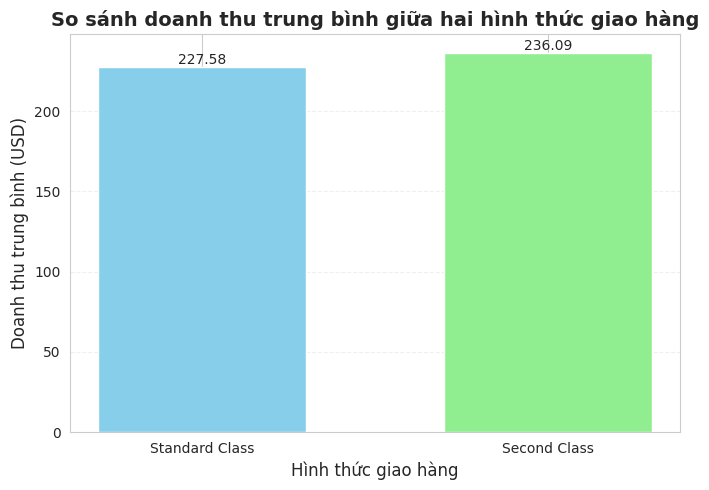

In [411]:
# Dữ liệu
modes = ['Standard Class', 'Second Class']
avg_sales = [227.58, 236.09]

# Tạo biểu đồ
plt.figure(figsize=(7,5))
bars = plt.bar(modes, avg_sales, color=['skyblue', 'lightgreen'], width=0.6)

# Thêm tiêu đề và nhãn trục
plt.title('So sánh doanh thu trung bình giữa hai hình thức giao hàng', fontsize=14, fontweight='bold')
plt.ylabel('Doanh thu trung bình (USD)', fontsize=12)
plt.xlabel('Hình thức giao hàng', fontsize=12)

# Thêm label trên đầu cột (hiển thị giá trị)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., # x-coordinate: center of the bar
             height,                          # y-coordinate: top of the bar
             f'{height:.2f}',                 # text: formatted height
             ha='center', va='bottom', fontsize=10) # alignment

# Làm đẹp biểu đồ
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

NHẬN XÉT

- Doanh thu trung bình của hai nhóm (Standard Class: 227.58, Second Class: 236.09) có sự chênh lệch nhỏ, nhưng không đáng kể về mặt thống kê.

- Giá trị T-statistic = -0.5599 gần bằng 0, củng cố nhận định rằng mức doanh thu trung bình giữa hai hình thức giao hàng là tương đương.

- P-value = 0.5756 > 0.05, nghĩa là không đủ bằng chứng để bác bỏ giả thuyết H₀

→ Có thể kết luận rằng các yếu tố khác (như loại sản phẩm, khu vực, chính sách giá hoặc chiết khấu) mới là nguyên nhân chính ảnh hưởng đến doanh thu, chứ không phải hình thức giao hàng

**Kiểm định ANOVA: So sánh doanh thu trung bình giữa các khu vực (Region)**

* Giả thuyết (H0): Doanh thu trung bình giữa các khu vực là bằng nhau

* Đối thuyết (H1): Có ít nhất một khu vực có doanh thu trung bình khác biệt đáng kể so với các khu vực còn lại

In [412]:
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Gather sales data per region
region_sales = [df[df['region'] == r]['sales'] for r in df['region'].unique()]

# Perform One-Way ANOVA
f_stat_anova, p_value_anova = f_oneway(*region_sales)

print("--- KẾT QUẢ KIỂM ĐỊNH ANOVA (Doanh thu theo Khu vực) ---")
print(f"F-Statistic: {f_stat_anova:.4f}, P-Value: {p_value_anova:.4f}")

if p_value_anova < 0.05:
    print("Bác bỏ H0: Có sự khác biệt đáng kể về doanh thu giữa các khu vực.")
else:
    print("Không bác bỏ H0: Chưa có bằng chứng cho thấy doanh thu khác biệt giữa các khu vực.")

# Display the formal ANOVA table for comprehensive output
formula = 'sales ~ C(region)'
lm = smf.ols(formula, data=df).fit()
anova_table = anova_lm(lm)
print("\nBảng ANOVA Chi tiết:")
print(anova_table)
print("\nDescriptive Statistics: Doanh thu trung bình theo từng khu vực")
print(df.groupby('region', observed=False)['sales'].mean().sort_values(ascending=False).round(2))

--- KẾT QUẢ KIỂM ĐỊNH ANOVA (Doanh thu theo Khu vực) ---
F-Statistic: 0.8006, P-Value: 0.4933
Không bác bỏ H0: Chưa có bằng chứng cho thấy doanh thu khác biệt giữa các khu vực.

Bảng ANOVA Chi tiết:
               df        sum_sq        mean_sq         F   PR(>F)
C(region)     3.0  9.330200e+05  311006.661044  0.800619  0.49332
Residual   9990.0  3.880692e+09  388457.706898       NaN      NaN

Descriptive Statistics: Doanh thu trung bình theo từng khu vực
region
South       241.8
East       238.34
West       226.49
Central    215.77
Name: sales, dtype: Float64


NHẬN XÉT

* P-value = 0.4933 lớn hơn 0.05 → không có đủ bằng chứng để kết luận rằng khu vực bán hàng ảnh hưởng đến doanh thu

* Bảng ANOVA cho thấy phần phương sai giữa các khu vực (sum_sq = 933,020) rất nhỏ so với phần phương sai còn lại (sum_sq = 3,880,692,000).
→ Điều này cho thấy sự khác biệt doanh thu giữa các khu vực là rất nhỏ so với biến động chung trong toàn bộ dữ liệu.

* Doanh thu phân bố khá đồng đều giữa các khu vực, sự khác biệt quan sát được chỉ là ngẫu nhiên, không đủ mạnh để khẳng định có sự khác biệt thực sự

**Kiểm định Chi-square: Mối quan hệ giữa Phân khúc khách hàng (Segment) và Hình thức giao hàng (Ship Mode)**

* Giả thuyết (H0): Phân khúc khách hàng và hình thức giao hàng độc lập với nhau (không có mối liên hệ)

* Đối thuyết (H1): Phân khúc khách hàng và hình thức giao hàng có mối liên hệ phụ thuộc lẫn nhau

In [413]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['segment'], df['ship_mode'])

# Perform the Chi-squared Test for Independence
# H0: Segment and Ship Mode are independent
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print("--- KẾT QUẢ KIỂM ĐỊNH CHI-BÌNH PHƯƠNG (Segment và Ship Mode) ---")
print(f"Chi2-Statistic: {chi2_stat:.4f}, P-Value: {p_value_chi2:.4f}, Degrees of Freedom: {dof}")

if p_value_chi2 < 0.05:
    print("Kết luận: Bác bỏ H0. Có mối quan hệ giữa Phân khúc khách hàng (Segment) và Hình thức giao hàng (Ship Mode)")
else:
    print("Kết luận: Không bác bỏ H0. Chưa có bằng chứng cho thấy có mối quan hệ giữa Segment và Ship Mode")

print("\nContingency Table:")
print(contingency_table)

--- KẾT QUẢ KIỂM ĐỊNH CHI-BÌNH PHƯƠNG (Segment và Ship Mode) ---
Chi2-Statistic: 28.0979, P-Value: 0.0001, Degrees of Freedom: 6
Kết luận: Bác bỏ H0. Có mối quan hệ giữa Phân khúc khách hàng (Segment) và Hình thức giao hàng (Ship Mode)

Contingency Table:
ship_mode    First Class  Same Day  Second Class  Standard Class
segment                                                         
Consumer             769       317          1020            3085
Corporate            485       114           609            1812
Home Office          284       112           316            1071


NHẬN XÉT

* Cả ba phân khúc đều có tỷ lệ dùng “Standard Class” cao nhất, cho thấy đây là hình thức giao hàng phổ biến nhất.

* Consumer là nhóm dùng “Same Day” nhiều nhất về số lượng tuyệt đối (317 đơn), cho thấy nhu cầu giao nhanh cao hơn.

* Home Office chiếm tỷ lệ nhỏ hơn trong tất cả các loại hình giao hàng

* Doanh nghiệp có thể dựa vào đặc điểm từng phân khúc để điều chỉnh chính sách vận chuyển - ví dụ:

    Tăng cường dịch vụ “Same Day” cho nhóm Consumer,

    Duy trì dịch vụ “First Class” cho nhóm Corporate,

    Tối ưu chi phí giao hàng tiêu chuẩn cho Home Office.

**Kiểm định: Customer Segment (phân khúc khách hàng) có ảnh hưởng đáng kể đến lợi nhuận trung bình trên mỗi đơn hàng (Average Profit per Order) hay không?**

* Giả thuyết H0: Trung bình lợi nhuận trên mỗi đơn hàng không khác nhau giữa các nhóm khách hàng

* Đối thuyết H1: Có ít nhất một nhóm khách hàng có trung bình lợi nhuận khác biệt đáng kể so với nhóm khác.


In [414]:
from scipy import stats

# Tính profit trung bình trên mỗi đơn hàng cho từng nhóm khách hàng
grouped = df.groupby('segment')['profit'].mean()

# Chuẩn bị dữ liệu cho kiểm định ANOVA
segment_groups = [df[df['segment'] == seg]['profit'] for seg in df['segment'].unique()]

# Thực hiện kiểm định ANOVA một yếu tố
f_stat, p_value = stats.f_oneway(*segment_groups)

# In kết quả
print("=== Kết quả ANOVA test ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Kết luận
if p_value < 0.05:
    print("=> Kết luận: Customer Segment ảnh hưởng ĐÁNG KỂ đến Average Profit per Order (có ý nghĩa thống kê).")
else:
    print("=> Kết luận: KHÔNG có sự khác biệt đáng kể về Average Profit per Order giữa các Customer Segment.")


=== Kết quả ANOVA test ===
F-statistic: 0.8981
P-value: 0.4074
=> Kết luận: KHÔNG có sự khác biệt đáng kể về Average Profit per Order giữa các Customer Segment.


NHẬN XÉT

- Giá trị F = 0.8981 và p-value = 0.4074 > 0.05, cho thấy không đủ bằng chứng thống kê để bác bỏ giả thuyết H₀. Điều đó có nghĩa là lợi nhuận trung bình trên mỗi đơn hàng (Average Profit per Order) không khác biệt đáng kể giữa các nhóm khách hàng (Customer Segment).

- Nói cách khác, phân khúc khách hàng (Consumer, Corporate, Home Office) không ảnh hưởng rõ rệt đến lợi nhuận trung bình. Có thể các yếu tố khác như loại sản phẩm, chiết khấu, khu vực bán hàng hoặc phương thức giao hàng mới là những biến số tác động mạnh hơn đến lợi nhuận.

**Kiểm định hồi quy tuyến tính đa biến về các yếu tố ảnh hưởng đến lợi nhuận**

In [415]:
import statsmodels.api as sm
import numpy as np

# các cột: 'profit', 'sales', 'discount', 'category', 'ship_mode'

# Tạo biến giả (dummy variables) cho các biến phân loại
df_dummy = pd.get_dummies(df, columns=['category', 'ship_mode'], drop_first=False)

# Xác định biến độc lập (X) và biến phụ thuộc (y)
# Explicitly select only the numeric and dummy variables for X
X = df_dummy[['sales', 'discount', 'category_Furniture', 'category_Office Supplies',
              'category_Technology', 'ship_mode_First Class', 'ship_mode_Same Day',
              'ship_mode_Second Class', 'ship_mode_Standard Class']]
y = df_dummy['profit']

# Cast both X and y to standard NumPy float types
X = X.astype(np.float64)
y = y.astype(np.float64)


# Add a constant to the independent variables
X = sm.add_constant(X)

# Xây dựng mô hình hồi quy tuyến tính
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     552.4
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:31:12   Log-Likelihood:                -67077.
No. Observations:                9994   AIC:                         1.342e+05
Df Residuals:                    9986   BIC:                         1.342e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

NHẬN XÉT

* Mô hình hồi quy tuyến tính cho thấy Sales, Discount, và Category là các yếu tố ảnh hưởng có ý nghĩa thống kê đến lợi nhuận
  * Doanh thu (Sales) là yếu tố tích cực, có ảnh hưởng mạnh nhất đến lợi nhuận, khi doanh thu tăng, lợi nhuận tăng tương ứng
  * Chiết khấu (Discount) là yếu tố tiêu cực, ảnh hưởng mạnh nhất – cần kiểm soát chặt chính sách giảm giá vì nó làm giảm đáng kể lợi nhuận (vì mức chiết khấu càng cao thì lợi nhuận giảm mạnh)
  * Loại sản phẩm (Category) có ảnh hưởng đáng kể, trong đó Office Supplies và Technology mang lại lợi nhuận tốt hơn nhóm tham chiếu (Furniture)
  * Hình thức giao hàng (Ship Mode) không ảnh hưởng rõ rệt đến lợi nhuận, khớp với kết quả kiểm định T-test trước đó

## 4. Kết quả

**Kết quả chính**

* Office Supplies: doanh số cao nhất nhưng lợi nhuận thấp – giúp duy trì dòng tiền.

* Furniture: doanh thu lớn nhưng biên lợi nhuận chỉ ~2.5% → rủi ro tài chính cao.

* Technology: dẫn đầu cả doanh thu và lợi nhuận → mảng cốt lõi nên tập trung đầu tư.

* Tables & Bookcases lỗ nặng, Copiers sinh lời tốt nhất.

* Chiết khấu cao làm giảm mạnh lợi nhuận, nhưng không giúp tăng doanh số đáng kể.

**Theo vùng và khách hàng**

* West & East: dẫn đầu về cả doanh thu và lợi nhuận.

* Central: doanh số trung bình nhưng lợi nhuận thấp → cần tối ưu vận hành.

* South: doanh số thấp nhưng tỷ suất lợi nhuận khá ổn.

* Khách hàng Consumer & Corporate chiếm ~80% doanh thu; nhóm Home Office tuy nhỏ nhưng hiệu quả

**Diễn biến theo thời gian**

* Doanh thu và lợi nhuận tăng mạnh vào cuối năm, đặc biệt dịp lễ.

* Tuy nhiên, tăng doanh thu không luôn đi kèm tăng lợi nhuận, cho thấy vấn đề trong quản lý chi phí hoặc chính sách giảm giá.

**Phân tích tương quan**

* Discount – Profit: Tương quan âm yếu (-0.22) — chiết khấu cao làm giảm lợi nhuận đáng kể.
* Doanh thu (Sales) và Lợi nhuận (Profit) có tương quan dương vừa phải (0.48), nghĩa là tăng doanh thu không luôn đồng nghĩa với tăng lợi nhuận — có thể do ảnh hưởng của chiết khấu hoặc chi phí.

## 5. Kết luận

* Phân tích mô tả cho thấy doanh thu có xu hướng biến động theo mùa, với các giai đoạn tăng mạnh vào giữa và cuối năm. Phương thức vận chuyển “Standard Class” chiếm tỷ trọng đơn hàng lớn nhất, trong khi “Same Day” có thời gian giao hàng ngắn nhất nhưng chi phí cao hơn.

* Kết quả phân tích tương quan chỉ ra rằng chiết khấu có mối quan hệ nghịch với lợi nhuận và biên lợi nhuận, cho thấy việc giảm chiết khấu có thể giúp cải thiện hiệu quả kinh doanh nếu không làm giảm đáng kể doanh thu.

* Mô hình Holt–Winters Exponential Smoothing cho thấy doanh thu dự kiến sẽ tiếp tục tăng nhẹ trong 6–12 tháng tới, phản ánh xu hướng tích cực nhưng có yếu tố dao động theo mùa.

* Các kịch bản giả định về việc giảm chiết khấu xuống ở mức dưới 20% có thể giúp tối ưu lợi nhuận tổng thể mà không ảnh hưởng lớn đến doanh thu. Điều này cung cấp căn cứ cho việc điều chỉnh chính sách chiết khấu nhằm cân bằng giữa tăng trưởng doanh thu và biên lợi nhuận.